In [1]:
%load_ext autoreload
import sys
sys.path.append("../..")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
%matplotlib inline

In [3]:
%autoreload

import matplotlib
matplotlib.rc_file('../matplotlibrc')
import matplotlib.pyplot as plt
import pickle

import numpy as np
from scipy.interpolate import interp1d

import darkhistory.physics as phys
import darkhistory.low_energy.atomic as atomic
import darkhistory.low_energy.bound_free as bf
import main

In [4]:
from config import load_data
from darkhistory.spec.spectrum import Spectrum
import darkhistory.spec.spectools as spectools
binning = load_data('binning')

In [6]:
from tqdm import tqdm_notebook as tqdm
from scipy.integrate import solve_ivp

### Reproducing case-B Recombination Coefficients

In [7]:
rs_vec = 10**np.arange(1,4,.1)
Tr_vec = phys.TCMB(rs_vec)
Tm_vec = phys.Tm_std(rs_vec)
length = len(rs_vec)

In [8]:
def alpha_recomb_full_Kot(T_over_rydberg):
    return (
        8.414*(np.log(1 + 1./T_over_rydberg) + 3.499) * (phys.alpha**4 * phys.c * phys.bohr_rad**2) 
        / (T_over_rydberg**0.5 + 0.6517*T_over_rydberg +   0.2138*T_over_rydberg**(3/2))
    )
def alpha_recomb_1_Kot(T_over_rydberg):
    return (
        17.41 * (phys.alpha**4 * phys.c * phys.bohr_rad**2) 
        / (T_over_rydberg**0.5 + 0.3593*T_over_rydberg**(7/6) + 0.1471*T_over_rydberg**(3/2))
    )

In [9]:
# Tm^1/2 * alpha_B from Hummer 1994 MNRAS
Tm_alphaB_Hummer = np.array([
    9.283e-11, 8.823e-11, 8.361e-11,
    7.898e-11, 7.435e-11, 6.973e-11,
    6.512e-11, 6.054e-11, 5.599e-11,
    5.147e-11, 4.700e-11, 4.258e-11,
    3.823e-11, 3.397e-11, 2.983e-11,
    2.584e-11, 2.204e-11, 1.847e-11,
    1.520e-11, 1.226e-11, 9.696e-12,
    7.514e-12, 5.710e-12, 4.257e-12,
    3.117e-12, 2.244e-12, 1.590e-12,
    1.110e-12, 7.642e-13, 5.199e-13,
3.498e-13])

#Convert to eV
Tm_Hummer = 10**np.arange(1,7.2,.2)*phys.kB

alphaB_Hummer = interp1d(Tm_Hummer, Tm_alphaB_Hummer/np.sqrt(Tm_Hummer/phys.kB))

In [12]:
%autoreload
# alpha_B requires many excited states to converge (see Hummer Fig. 1)
nmax = 100
Delta_f = lambda a : 0

alpha_tot=np.zeros(length)
alpha_tot_Hongwan=np.zeros(length)
for i, rs in enumerate(rs_vec):
    Tm = phys.Tm_std(rs)

#     k2_tab, g = atomic.populate_k2_and_g(nmax, Tm)
#     alpha = atomic.populate_alpha(Tm, phys.TCMB(rs)/1e20, nmax, k2_tab, g)
#     alpha_tot[i] = np.sum(alpha)
    alpha_tot_Hongwan[i] = bf.alpha_B(Tm,stimulated_emission=False, n=nmax)
    print(rs, alpha_tot_Hongwan[i])
    
#!!! Need to double-check the stimulated emission coefficient

10.0 5.5344162261919e-11
12.589254117941675 4.368832247897746e-11
15.848931924611142 3.4453299250783654e-11
19.952623149688808 2.7089105761398057e-11
25.11886431509582 2.123071189941004e-11
31.622776601683825 1.6591391903813416e-11
39.81071705534978 1.2936943420926838e-11
50.1187233627273 1.0074567151842763e-11
63.09573444801943 7.849919216241529e-12
79.4328234724283 6.132512063374792e-12
100.0000000000002 4.818262322528516e-12
125.89254117941701 3.81749524767936e-12
158.48931924611173 3.0564762078902656e-12
199.5262314968885 2.475981923428687e-12
251.18864315095874 2.031865392917588e-12
316.2277660168389 1.6852229128825303e-12
398.1071705534986 1.4098520499740566e-12
501.18723362727405 1.1863263639824714e-12
630.9573444801956 1.0004487368220872e-12
794.3282347242846 8.440255641516813e-13
1000.0000000000041 7.11866910892566e-13
1258.9254117941725 5.989855990675507e-13
1584.8931924611206 5.02505558173915e-13
1995.262314968889 4.2022438774713324e-13
2511.8864315095925 3.501749752503277e-

In [13]:
if nmax==10:
    alpha_tot10 = alpha_tot.copy()
elif nmax==20:
    alpha_tot20 = alpha_tot.copy()
elif nmax==50:
    alpha_tot50 = alpha_tot.copy()
elif nmax==100:
    alpha_tot100 = alpha_tot.copy()
elif nmax==300:
    alpha_tot300 = alpha_tot.copy()

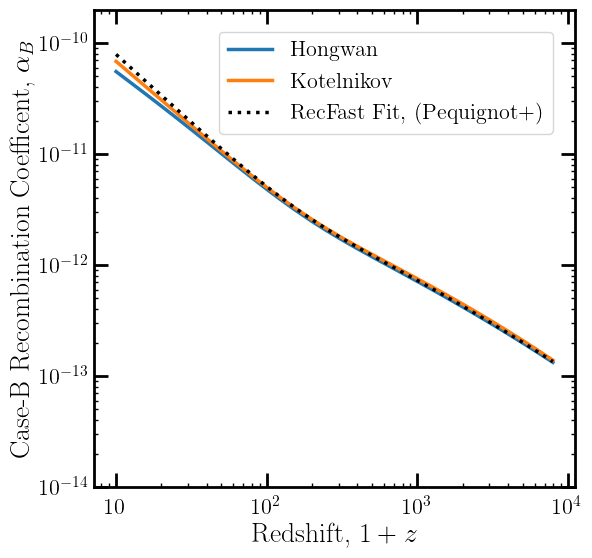

In [14]:
plt.figure()
plt.loglog()
plt.ylim([1e-14,2e-10])

# plt.plot(rs_vec[Tm_vec>8e-4], alphaB_Hummer(Tm_vec[Tm_vec>8e-4]), label='Hummer 1994')

# plt.plot(rs_vec, alpha_tot10, label=r'DH, $n_{\mathrm{max}}=10$')
# plt.plot(rs_vec, alpha_tot20, label=r'DH, $n_{\mathrm{max}}=20$')
# plt.plot(rs_vec, alpha_tot50, label=r'DH, $n_{\mathrm{max}}=50$')
# plt.plot(rs_vec, alpha_tot100, label=r'DH, $n_{\mathrm{max}}=100$')
# plt.plot(rs_vec, alpha_tot300, label=r'DH, $n_{\mathrm{max}}=300$')

plt.plot(rs_vec, alpha_tot_Hongwan, label=r'Hongwan')

tmp = alpha_recomb_full_Kot(Tm_vec/phys.rydberg)-alpha_recomb_1_Kot(Tm_vec/phys.rydberg)
plt.plot(rs_vec, tmp, label=r'Kotelnikov')
plt.plot(rs_vec, phys.alpha_recomb(Tm_vec, 'HI')/1.125, label='RecFast Fit, (Pequignot+)', color='k', linestyle=':')
plt.xlabel(r'Redshift, $1+z$', fontsize=20)
plt.ylabel(r'Case-B Recombination Coefficent, $\alpha_B$', fontsize=20)
plt.legend()

$\beta_B$ is obtained by detailed balance. 
First, use $x_i \beta_i \sim \frac1{g_i}e^{-E_i/T_m}\alpha_i$.
Next, assume $x_i = x_{2s}\frac{g_i}{g_{2s}} e^{-(E_2-E_i)/T_m}$. 
Finally, write the ionization term in the $x_e$ evolution equation as 
$$
\sum_i \beta_i x_i = x_{2s}\frac{g_i}{g_{2s}} e^{-(E_2-E_i)/T_m} \sim x_{2s}e^{-E_2/T_m} \alpha_B \sim \beta_B x_{2s}
$$
So a cross-cheeck of $\alpha_B$ is a cross-check of $\beta_B$.

# Deviations from TLA Assumptions

The TLA assumes that the excited states obey the detailed balance condition
$$
\begin{alignat}{1}
	\frac{x_i}{x_{2s}} = g_i e^{-(E_i-E_\alpha)/T} \, ,
\end{alignat}
$$
that the $n=2$ state obeys
$$
\begin{alignat}{1}
	x_2 = & \frac{x_{1s}e^{-E_\alpha/T} (3 R_{\text{Ly}\alpha} + \Lambda_{2s}) + x_e^2 n_H \alpha_\text{B}}{
	\frac34 R_{\text{Ly}\alpha} + \frac14 \Lambda_{2s} + \beta_\text{B}}   \, ,
\end{alignat}
$$
and that the substates satisfy 
$$
\begin{alignat}{1}
	x_{2p} = & \frac34 x_2 \\
    x_{2s} = & \frac14 x_2 \, .
\end{alignat}
$$

We also assume that the excited state abundances are so exponentially suppressed that $$x_{1s} = 1-x_e \, .$$
Let us now see if we can reproduce this behavior.

In [15]:
%autoreload
rs_vec  = 10**np.arange(1,4.55,.01)
Tr_vec  = phys.TCMB(rs_vec)
Tm_vec  = phys.Tm_std(rs_vec)

length  = len(rs_vec)

xe_vec  = phys.xHII_std(rs_vec)
x1s_vec = phys.xHI_std(rs_vec)
nH_vec  = phys.nH * rs_vec**3

tau_vec = atomic.tau_np_1s(2,rs_vec)
x2s_vec = atomic.x2s_steady_state(rs_vec, Tr_vec, Tm_vec, xe_vec, x1s_vec, tau_vec)
x2_vec  = 4*x2s_vec

In [213]:
def g_nl(l): return 2*l +1
def E(n): return phys.rydberg/n**2
hc = 2*np.pi*phys.hbar * phys.c

### Checking Detailed Balance

In [201]:
%autoreload

#Detailed Balance between recombination and ionization
rs = 3e3
Tr = phys.TCMB(rs)
Tm = Tr#phys.Tm_std(rs)
xe = phys.xHII_std(rs)
nH = phys.nH * rs**3
x1s = phys.xHI_std(rs)

nmax=9
new_switch=True
R = atomic.populate_radial(nmax)
BB = atomic.populate_bound_bound(nmax, Tr, R, Delta_f=Delta_f)
k2_tab, g = atomic.populate_k2_and_g(nmax, Tm)
alpha = atomic.populate_alpha(Tm, Tr, nmax, k2_tab, g, Delta_f=Delta_f, new_switch=new_switch)
beta = atomic.populate_beta(Tm, Tr, nmax, k2_tab, g, Delta_f=Delta_f, new_switch=new_switch)

hplanck=2*np.pi*phys.hbar
lam_T = hplanck*phys.c/(2*np.pi * phys.mu_ep * Tr)**(1/2)

for n in np.arange(1,nmax+1):
    for l in np.arange(0,n):
        fac = np.exp(phys.rydberg/n**2/Tr)*g_nl(l)*lam_T**3
        if new_switch:
            fac *= ((1/2*phys.mu_ep*phys.alpha**2)/phys.rydberg)**(3/2)
        
        print(n,l,':', beta[n][l]/alpha[n][l] * fac)

1 0 : 0.9999999999999992
2 0 : 1.0
2 1 : 0.9999999999999999
3 0 : 1.0000000000000004
3 1 : 1.0000000000000002
3 2 : 1.0000000000000004
4 0 : 1.0000000000000004
4 1 : 1.0000000000000004
4 2 : 1.0000000000000004
4 3 : 1.0000000000000004
5 0 : 1.0000000000000002
5 1 : 1.0000000000000002
5 2 : 1.0000000000000007
5 3 : 1.0
5 4 : 0.9999999999999997
6 0 : 1.0000000000000002
6 1 : 1.0000000000000004
6 2 : 1.0000000000000004
6 3 : 1.0000000000000004
6 4 : 1.0000000000000002
6 5 : 1.0000000000000007
7 0 : 1.0000000000000004
7 1 : 1.0000000000000004
7 2 : 1.0000000000000002
7 3 : 1.0000000000000004
7 4 : 1.0
7 5 : 1.0000000000000007
7 6 : 1.0
8 0 : 1.0000000000000002
8 1 : 1.0
8 2 : 1.0000000000000004
8 3 : 1.0000000000000004
8 4 : 1.0000000000000007
8 5 : 1.0000000000000004
8 6 : 1.0000000000000004
8 7 : 1.0
9 0 : 0.9999999999999997
9 1 : 0.9999999999999999
9 2 : 0.9999999999999997
9 3 : 0.9999999999999998
9 4 : 0.9999999999999998
9 5 : 1.0
9 6 : 1.0
9 7 : 1.0000000000000002
9 8 : 1.000000000000

In [202]:
%autoreload
#Saha equilibrium

rhs = lam_T**-3 / (phys.nH*rs**3) * np.exp(-phys.rydberg/Tr)
phys.xHI_std(rs) * rhs/xe**2

0.9999999999999999

In [101]:
#The main discrepancy comes from the fact that 
#this quantity doesn't keep track of stimulated emission

phys.alpha_recomb(Tr,'HI')/1.125

3.0849766757476206e-13

In [102]:
bf.alpha_B(Tr, T_r=Tr, stimulated_emission=False, f_gamma=None, n=100)

3.035234831208717e-13

In [103]:
bf.alpha_B(Tr, T_r=Tr, stimulated_emission=True, f_gamma=None, n=100)

8.381778979913012e-13

In [104]:
%autoreload
lam_T = hc/(2*np.pi * phys.mu_ep * Tr)**(1/2)
bf.beta_B(Tr,100) * np.exp(phys.rydberg/4 / Tr)*lam_T**3 * 4

8.381778979913006e-13

In [105]:
# The main discrepancy comes from stimulated emission
bf.beta_B(Tr,300)

3895924.5018236106

In [106]:
phys.beta_ion(Tr,'HI')

1242495.87664493

In [203]:
# Detailed Balance amongst the bound-bound transition rates
print('n1 l n2')
n1,l = 1,0
for n2 in np.arange(2,nmax+1):
    Ennp = E(n1)-E(n2)
    print(n1,'',l,n2,':',
          BB['up'][n1][n2][l]/(BB['dn'][n2][n1][l+1])/(
         np.exp(-Ennp/Tr)*g_nl(l+1)/g_nl(l)))
for n1 in np.arange(2,nmax+1):
    for n2 in np.arange(1,n1):
        for l in np.arange(1,n2):
            Ennp = E(n1)-E(n2)
            print(n1,'',l,n2,':',
                  BB['dn'][n1][n2][l]/(BB['up'][n2][n1][l-1])/(
                 np.exp(-Ennp/Tr)*g_nl(l-1)/g_nl(l)))

n1 l n2
1  0 2 : 1.0000000000000002
1  0 3 : 1.0000000000000002
1  0 4 : 0.9999999999999999
1  0 5 : 0.9999999999999998
1  0 6 : 0.9999999999999999
1  0 7 : 1.0000000000000002
1  0 8 : 1.0
1  0 9 : 0.9999999999999998
3  1 2 : 1.0
4  1 2 : 1.0
4  1 3 : 1.0
4  2 3 : 0.9999999999999999
5  1 2 : 0.9999999999999991
5  1 3 : 0.9999999999999997
5  2 3 : 0.9999999999999998
5  1 4 : 1.0
5  2 4 : 0.9999999999999998
5  3 4 : 1.0000000000000002
6  1 2 : 1.0000000000000002
6  1 3 : 1.0
6  2 3 : 0.9999999999999999
6  1 4 : 1.0
6  2 4 : 1.0
6  3 4 : 1.0
6  1 5 : 1.0
6  2 5 : 0.9999999999999997
6  3 5 : 1.0
6  4 5 : 0.9999999999999999
7  1 2 : 1.0
7  1 3 : 1.0
7  2 3 : 0.9999999999999999
7  1 4 : 0.9999999999999999
7  2 4 : 1.0
7  3 4 : 1.0
7  1 5 : 1.0000000000000002
7  2 5 : 1.0
7  3 5 : 1.0000000000000004
7  4 5 : 1.0000000000000002
7  1 6 : 1.0000000000000002
7  2 6 : 1.0000000000000002
7  3 6 : 1.0000000000000002
7  4 6 : 1.0
7  5 6 : 1.0000000000000002
8  1 2 : 0.9999999999999999
8  1 3 : 0.9999

In [108]:
print('n1 l n2')
for n1 in np.arange(2,nmax+1):
    for n2 in np.arange(1,n1):
        for l in np.arange(1,n2):
            Ennp = E(n1)-E(n2)
            print(n1,'',l,n2,':',
                  BB['dn'][n1][n2][l]/(BB['up'][n2][n1][l-1])/(
                 np.exp(-Ennp/Tr)*g_nl(l-1)/g_nl(l)))

n1 l n2
3  1 2 : 1.0
4  1 2 : 1.0
4  1 3 : 1.0
4  2 3 : 0.9999999999999999
5  1 2 : 0.9999999999999991
5  1 3 : 0.9999999999999997
5  2 3 : 0.9999999999999998
5  1 4 : 1.0
5  2 4 : 0.9999999999999998
5  3 4 : 1.0000000000000002
6  1 2 : 1.0000000000000002
6  1 3 : 1.0
6  2 3 : 0.9999999999999999
6  1 4 : 1.0
6  2 4 : 1.0
6  3 4 : 1.0
6  1 5 : 1.0
6  2 5 : 0.9999999999999997
6  3 5 : 1.0
6  4 5 : 0.9999999999999999
7  1 2 : 1.0
7  1 3 : 1.0
7  2 3 : 0.9999999999999999
7  1 4 : 0.9999999999999999
7  2 4 : 1.0
7  3 4 : 1.0
7  1 5 : 1.0000000000000002
7  2 5 : 1.0
7  3 5 : 1.0000000000000004
7  4 5 : 1.0000000000000002
7  1 6 : 1.0000000000000002
7  2 6 : 1.0000000000000002
7  3 6 : 1.0000000000000002
7  4 6 : 1.0
7  5 6 : 1.0000000000000002
8  1 2 : 0.9999999999999999
8  1 3 : 0.9999999999999998
8  2 3 : 1.0
8  1 4 : 1.0000000000000002
8  2 4 : 1.0
8  3 4 : 1.0
8  1 5 : 0.9999999999999998
8  2 5 : 0.9999999999999999
8  3 5 : 1.0
8  4 5 : 1.0
8  1 6 : 1.0000000000000002
8  2 6 : 1.00000000

In [109]:
#Saha equilibrium at large redshift between xe = xHII and x1s ~ xHI
hc = 2*np.pi * phys.hbar*phys.c
mu_e = phys.me/(1+phys.me/phys.mp)
lam_T = hc/(2*np.pi * mu_e*Tr_vec)**(1/2)

(phys.xHI_std(rs_vec)/nH_vec/xe_vec**2)*np.exp(-E(1)/Tr_vec)/g_nl(0)/lam_T**3

array([0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0

### Understanding $\beta_{MLA}$ and $\alpha_{MLA}$

In [110]:
# Undetailed balance: Seeing that each line of the MLA is satisfied 
# by x_i in LTE

num_states = int((n+1)*n/2)
states_n = np.concatenate([list(map(int,k*np.ones(k))) for k in range(1,nmax+1,1)])
states_l = np.concatenate([np.arange(k) for k in range(1,nmax+1)])

x_lte = np.zeros(num_states)
x_lte[0] = x1s
for nl in np.arange(num_states):
    n = states_n[nl]
    l = states_l[nl]
    x_lte[nl] = g_nl(l) * np.exp((E(n)-E(1))/Tr) * x1s

diff_vec = np.zeros(num_states)

def nl_vec(n,l):
    return int((n-1)*n/2)+l

# x_tmp = np.zeros(num_states)
# x_tmp[0] = x1s

# for nl in np.arange(1, num_states):
#     n = states_n[nl]
#     l = states_l[nl]
#     x_tmp[nl] = g_nl(l) * np.exp((E(n)-E(1))/Tr) * x_tmp[0]
    

for nl in np.arange(1, num_states):
    n = states_n[nl]
    l = states_l[nl]
    R_tot = np.sum(BB['dn'][n, :, l] + BB['up'][n, :, l]) + beta[n][l]
    if nl != num_states-1:
        diff_vec[nl] = (-x_lte[nl] + np.sum(
            BB['dn'][1:,n,l+1]/R_tot*x_lte[np.array([nl_vec(n,l+1) for n in np.arange(1,nmax+1)])]
            +BB['up'][1:,n,l-1]/R_tot*x_lte[np.array([nl_vec(n,l-1) for n in np.arange(1,nmax+1)])]
        ) + xe**2 * nH * alpha[n][l]/R_tot)
    else:
        diff_vec[nl] = (-x_lte[nl] + np.sum(
            BB['up'][1:,n,l-1]/R_tot*x_lte[np.array([nl_vec(n,l-1) for n in np.arange(1,nmax+1)])]
        ) + xe**2 * nH * alpha[n][l]/R_tot)
        
    if nl==1:
#         diff_vec[nl] -= BB['dn'][2,1,0]/R_tot*x_lte[1]
        diff_vec[nl] += BB['dn'][2,1,0]*np.exp((E(2)-E(1))/Tr)/R_tot*x_lte[0]
        
    print(n,l,diff_vec[nl]/x_lte[nl])
    
print(np.linalg.norm(diff_vec)/np.linalg.norm(x_lte))

2 0 4.668917149747172e-16
2 1 5.3612157280822e-16
3 0 -1.1158988923751275e-15
3 1 -1.9122211066522137e-16
3 2 -1.167764615541859e-15
4 0 2.1687042314226585e-15
4 1 4.953213368064096e-16
4 2 1.9277370945979186e-15
4 3 2.5186803110966856e-15
5 0 4.960016261403872e-16
5 1 0.0
5 2 3.1000101633774196e-16
5 3 7.085737516291245e-17
5 4 -3.6511230813111836e-16
6 0 5.887032742429433e-16
6 1 -1.700698347812947e-16
6 2 -3.139750795962364e-16
6 3 -2.466947053970429e-16
6 4 1.875128947588634e-16
6 5 9.365733908410462e-16
7 0 -2.5337429841951354e-15
7 1 -9.0490820864112e-16
7 2 -2.9138044318244054e-15
7 3 -3.024978868886029e-15
7 4 -2.825324518090608e-15
7 5 -2.5748751754970043e-15
7 6 -2.4067077933666706e-15
8 0 -4.962096541070434e-17
8 1 -9.924193082140867e-17
8 2 -7.343902880784242e-16
8 3 -2.55193536397908e-16
8 4 -7.71881684166512e-17
8 5 2.7065981133111455e-16
8 6 8.397394146426888e-16
8 7 6.798072261266494e-16
9 0 1.2687103641443744e-15
9 1 1.7620977279782976e-17
9 2 7.189358730151454e-16
9 3

In [73]:
def delta_distortion(nmax, rs, x_nl, BB, photeng, dlnz, include_2s = True, spec_2s1s = None):

    num_states = (int) (nmax*(nmax-1)/2)
    states_n = np.concatenate([list(map(int,k*np.ones(k))) for k in range(1,nmax+1,1)])
    states_l = np.concatenate([np.arange(k) for k in range(1,nmax+1)])

    def E(n): return phys.rydberg/n**2
    nH = phys.nH * rs**3
    nB = phys.nB * rs**3

    dt = dlnz/phys.hubble(rs)

    #initialize
    E_current = 0
    ind_current = 0
    H_engs = np.zeros(num_states)
    Nphot_cascade = H_engs.copy()


    for nl in np.arange(num_states):
        n = states_n[nl]
        l = states_l[nl]

        # If this state has a new energy, add to the list of photon energies
        # Add nmax-n more indices, you'll end up with nmax(nmax-1)/2
        if E_current != E(n):

            #Start by filling from 0 to nmax-1
            if n>1:
                ind_current += nmax-n+1

            E_current = E(n)
            H_engs[ind_current:ind_current + nmax-n] = E(n)-E(np.arange(n+1,nmax+1))


        # photons from l <-> l+1 transitions
        if l<nmax-1:
            # Number of photons injected per baryon
            Nphot_cascade[ind_current:ind_current + nmax-n] += nH*(
                x_nl[(states_l == l+1) * (states_n>n)] * BB['dn'][n+1:,n,l+1] #Downscattering adds photons
                -x_nl[nl] * BB['up'][n,n+1:,l] #upscattering subtracts them
            )/nB * dt
            
        #NOTE: 'dn' and 'up' have nothing to do with down- or up-scattering, 
        # just if the l quantum number go up or down
        
        # photons from l <-> l-1 transitions
        if l>0:
            Nphot_cascade[ind_current:ind_current + nmax-n] += nH * ( 
                x_nl[(states_l == l-1) * (states_n>n)] * BB['up'][n+1:,n,l-1] #Downscattering
                -x_nl[nl] * BB['dn'][n,n+1:,l] #upscattering
            )/nB * dt
            
    # Make a spectrum
    data = np.array(sorted(np.flipud(np.transpose([H_engs,Nphot_cascade])), key=lambda pair:pair[0]))
    transition_spec = Spectrum(data[:,0], data[:,1], spec_type='N', rs=rs)
    transition_spec.rebin(photeng)
        
    if include_2s:
        # Then add the two photon transitions
        #!!! Tm or Tr in detailed balance?
        amp_2s1s = nH * BB['dn'][2,1,0] * (x_nl[1] - x_nl[0]*np.exp(-phys.lya_eng/phys.TCMB(rs))) / nB * dt
        if (rs>1000 and rs<1640):
            print(BB['dn'][2,1,0] * (x_nl[1] - x_nl[0]*np.exp(-phys.lya_eng/phys.TCMB(rs))), "to", jens_2s_interp(rs))
            amp_2s1s = 1e-11 * jens_2s_interp(rs) / nB * dt
            
        if spec_2s1s == None:
            spec_2s1s = spectools.discretize(photeng, phys.dNdE_2s1s)
        transition_spec.N += amp_2s1s * spec_2s1s.N

    return transition_spec

In [84]:
%autoreload

from darkhistory.spec.spectra import Spectra

hplanck = phys.hbar * 2*np.pi
def Delta_f(E): return 0
def g_nl(l): return 2*l +1
def E(n): return phys.rydberg/n**2
hc = 2*np.pi*phys.hbar * phys.c

dlnz = .001
rs_vec  = np.exp(np.arange(np.log(5e2),np.log(3.5e3),dlnz))
Tr_vec  = phys.TCMB(rs_vec)
# Tm_vec  = phys.Tm_std(rs_vec)
Tm_vec = Tr_vec.copy()

length  = len(rs_vec)

xe_vec  = phys.xHII_std(rs_vec)
x1s_vec = phys.xHI_std(rs_vec)

nH_vec  = phys.nH * rs_vec**3

tau_vec = atomic.tau_np_1s(2,rs_vec)
x2s_vec = atomic.x2s_steady_state(rs_vec, Tr_vec, Tm_vec, xe_vec, x1s_vec, tau_vec)
x2_vec  = 4*x2s_vec


# eng = binning['phot']
eng = np.exp(np.linspace(np.log(hplanck*1e8), np.log(phys.rydberg), 5000))
# eng = np.linspace(hplanck*1e8, phys.rydberg, 10000)
nmax=10
skip=1
include_2s = True
if include_2s:
    spec_2s1s = spectools.discretize(eng, phys.dNdE_2s1s)

num_states = int(nmax*(nmax+1)/2)
ident = np.identity(num_states-1)
R = atomic.populate_radial(nmax)

H_engs = atomic.get_transition_energies(nmax)
num_lines = H_engs.size-1

states_n = np.concatenate([list(map(int,k*np.ones(k))) for k in range(1,nmax+1,1)])
states_l = np.concatenate([np.arange(k) for k in range(1,nmax+1)])
exc_states = np.transpose([states_n,states_l])[1:]

x_vec = np.zeros((length,num_states-1))
x_lte = np.zeros(num_states) #equilibrium solution
x_lte[0] = x1s_vec[0]

beta_MLA = np.zeros(length)
alpha_MLA = np.zeros(length)
greg_2s = np.zeros(length)
greg_2p = np.zeros(length)

new_switch = True

#Store the distortion here
if nmax == 10:          distortion10  = Spectrum(eng, np.zeros_like(eng), spec_type='N', rs=1)
elif nmax == 20:        distortion20  = Spectrum(eng, np.zeros_like(eng), spec_type='N', rs=1)
else:               
    if not include_2s:  distortion30  = Spectrum(eng, np.zeros_like(eng), spec_type='N', rs=1)
    else:               full_dist  = Spectrum(eng, np.zeros_like(eng), spec_type='N', rs=1)
delta_dists = Spectra(np.zeros((len(rs_vec), len(eng))), eng=eng, spec_type='N', rs=rs_vec)

for i in tqdm(np.arange(0,length,skip)):#(-1,0):#(0,length,skip):
    rs = rs_vec[i]
    xe  = xe_vec[i]
    x1s = x1s_vec[i]
    x2s = x2s_vec[i]
    
    nH  = nH_vec[i]
    Tr = Tr_vec[i]
    Tm = Tm_vec[i]
    

    #Get the transition rates
    BB = atomic.populate_bound_bound(nmax, Tr, R, Delta_f=Delta_f)
    k2_tab, g = atomic.populate_k2_and_g(nmax, Tm)
    alpha = atomic.populate_alpha(Tm, Tr, nmax, k2_tab, g, Delta_f=Delta_f, new_switch=new_switch)
    beta = atomic.populate_beta(Tm, Tr, nmax, k2_tab, g, Delta_f=Delta_f, new_switch=new_switch)

    #Include sobolev optical depth
    for n in range(2,nmax+1):
        BB['dn'][n][1][1] *= atomic.p_np_1s(n, rs, xHI=x1s)
        BB['up'][1][n][0] *= atomic.p_np_1s(n, rs, xHI=x1s)

    ### Build transition probability matrix, P_ij (i,j of excited states)
    mat = np.zeros((num_states, num_states))
    b = np.zeros(num_states)
    for nl in np.arange(num_states):
#         print(rs, xe**2 * alpha[n][l]*nH)
        # Find indices for possible states to transition to (l must change by 1)
        # Get the rates for transitioning to those states, as well as total rate

        n = states_n[nl]
        l = states_l[nl]
        x_lte[nl] = g_nl(l) * np.exp((E(n)-E(1))/Tr) * x2s
        tot_rate = np.sum(BB['dn'][n,:,l]) + np.sum(BB['up'][n,:,l]) + beta[n][l]
        
        # Construct the matrix
        if l!= 0:
            mat[nl,states_l == l-1] = BB['up'][l:,n,l-1]/tot_rate
            
        if l!= nmax-1:
            mat[nl,states_l == l+1] = BB['dn'][l+2:,n,l+1]/tot_rate

        # Special 2s->1s transition
        if nl == 0:
            mat[0][1] = BB['dn'][2][1][0]/ tot_rate
        if nl == 1:
            #Detalied Balance
            mat[1][0] = BB['dn'][2][1][0]*np.exp((E(2)-E(1))/Tr) / tot_rate
            

        # Construct the inhomogeneous term
        b[nl] += xe**2 * nH * alpha[n][l]
        if l==1:
            b[nl] += x1s*BB['up'][1, n, 0]
        elif nl==1:
            # 1s to 2s transition from detailed balance
            b[nl] += x1s*BB['dn'][2][1][0]*np.exp(-phys.lya_eng/Tr)
            
        b[nl] /= tot_rate

    #Probability matrix for only the excited states
    M = ident - mat[1:,1:]
    
    x_vec[i] = np.linalg.solve(M,b[1:])
    # x_full = np.append(1-np.sum(x_vec[i])-xe, x_vec[i])
    x_full = np.append(x1s, x_vec[i])
    
    for nl in np.arange(num_states):
        n, l = states_n[nl], states_l[nl]
        if nl > 0:
            beta_MLA[i]  += x_full[nl] * beta[n][l]
            alpha_MLA[i] += alpha[n][l] #* xe**2 * nH

    # norm = np.linalg.norm
    # print(rs, norm(x_full), norm(x_full-x_lte))
    # print(rs, x_full[1:3], x2s, x2s*3)

    transition_spec = delta_distortion(nmax, rs_vec[i], x_full, BB, eng, dlnz, include_2s = include_2s, spec_2s1s=spec_2s1s)
    delta_dists._grid_vals[i] = transition_spec.N
    transition_spec.redshift(1)
    
    greg_2s[i] = nH * BB['dn'][2,1,0] * (x_full[1] - x_full[0]*np.exp(-phys.lya_eng/phys.TCMB(rs)))
    greg_2p[i] = nH * (BB['dn'][2,1,1] * x_full[2] - BB['up'][1,2,0] * x_full[0])

    if nmax == 10:          distortion10.N += transition_spec.N
    elif nmax == 20:        distortion20.N += transition_spec.N
    else:            
        if not include_2s:  distortion30.N += transition_spec.N
        else:               full_dist.N    += transition_spec.N

[1.46378337e-17 1.47139172e-17 1.47903766e-17 ... 2.47118213e-09
 2.47656044e-09 2.48195028e-09] [3.22167491e-37 3.51123400e-37 3.82648829e-37 ... 3.92015566e-07
 3.91449418e-07 3.90878916e-07]


/var/folders/kq/gkzlnb6576x8mxsf32v72_y00000gn/T/ipykernel_2285/2772159375.py:68: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(np.arange(0,length,skip)):#(-1,0):#(0,length,skip):


  0%|          | 0/1946 [00:00<?, ?it/s]

1.7565076459176493e-14 to 0.3466027889996968
1.78049358466493e-14 to 0.35226971477934466
1.8047335107529327e-14 to 0.35794231031917956
1.8292291841416363e-14 to 0.3636205812917975
1.8539823619633163e-14 to 0.36930453337547026
1.878994798167087e-14 to 0.3749941722541503
1.9042682431593715e-14 to 0.38068950361747733
1.929804443452745e-14 to 0.38639053316078265
1.9556051412984466e-14 to 0.3923423435306613
1.9816720743228528e-14 to 0.3993424082762486
2.0080069751627155e-14 to 0.4063494765877807
2.0346115710972745e-14 to 0.4133635554723268
2.0614875836724958e-14 to 0.42038465194396585
2.088636728337646e-14 to 0.4274127730237961
2.1160607140629163e-14 to 0.43444792573993724
2.1437612429668748e-14 to 0.4414901171275448
2.17174000993849e-14 to 0.4485393542288084
2.200005370884004e-14 to 0.45559564409296766
2.2285551828734588e-14 to 0.4626589937763128
2.2573889235893524e-14 to 0.46972941034219284
2.2865082658632847e-14 to 0.47680690086102623
2.3159148733295882e-14 to 0.4838914724103036
2.345610

#Try cosmological parameters

In [82]:
phys.omega_m = 0.2678
phys.omega_baryon = 0.0444
phys.h = 0.71
phys.omega_lambda = 0.7322
phys.YHe = 0.24

In [83]:
phys.omega_m

0.2678

Text(0.5, 0, 'Redshift, $1+z$')

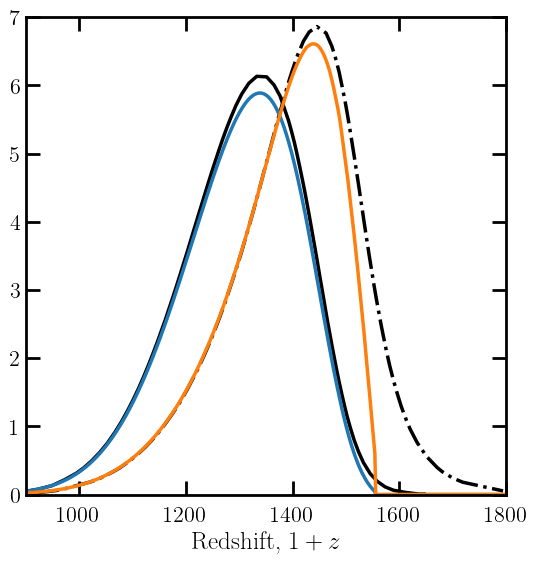

In [66]:
plt.figure()

plt.axis([900,1800,0,7])
plt.plot(jens_2s[:,0], jens_2s[:,1], color='k')
plt.plot(jens_2p[:,0], jens_2p[:,1], linestyle='dashdot', color='k')

plt.plot(rs_vec, 1e11*greg_2s)
plt.plot(rs_vec, 1e11*greg_2p)
# plt.axvline(1.5e3, color='k', linestyle=':')
plt.xlabel(r'Redshift, $1+z$')
# plt.ylabel(r'Distortion Energy Injected, $\Delta \epsilon_{inj}/n_B$')

Text(0, 0.5, 'Distortion Energy Injected, $\\Delta \\epsilon_{inj}/n_B$')

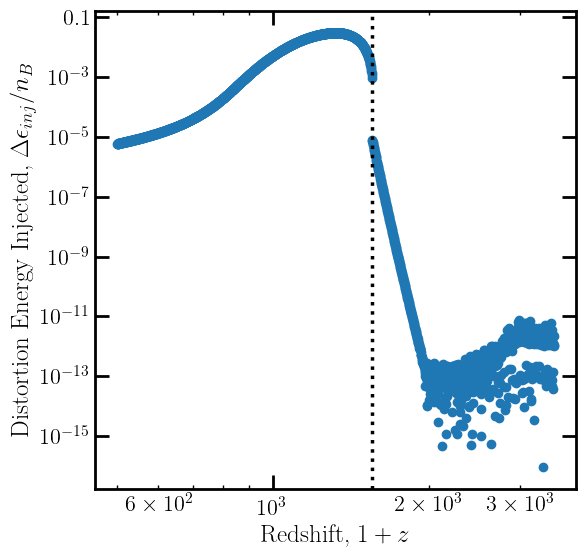

In [303]:
plt.figure()

plt.loglog()
plt.scatter(delta_dists.rs, np.abs(delta_dists.toteng()))
plt.axvline(1.555e3, color='k', linestyle=':')
# plt.axvline(1.5e3, color='k', linestyle=':')
plt.xlabel(r'Redshift, $1+z$')
plt.ylabel(r'Distortion Energy Injected, $\Delta \epsilon_{inj}/n_B$')

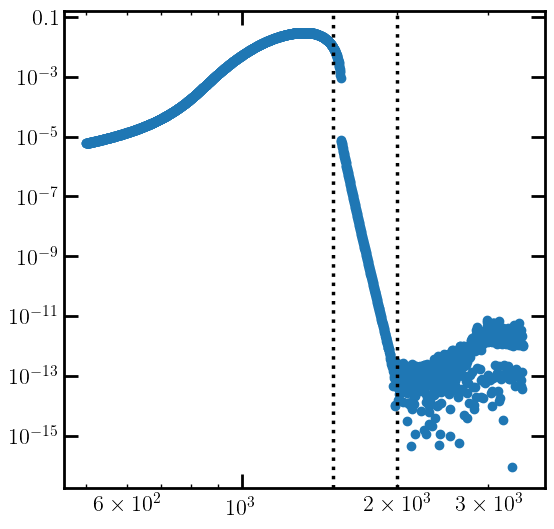

In [11]:
plt.figure()

plt.loglog()
plt.scatter(delta_dists.rs, np.abs(delta_dists.toteng()))
plt.axvline(2e3, color='k', linestyle=':')
plt.axvline(1.5e3, color='k', linestyle=':')

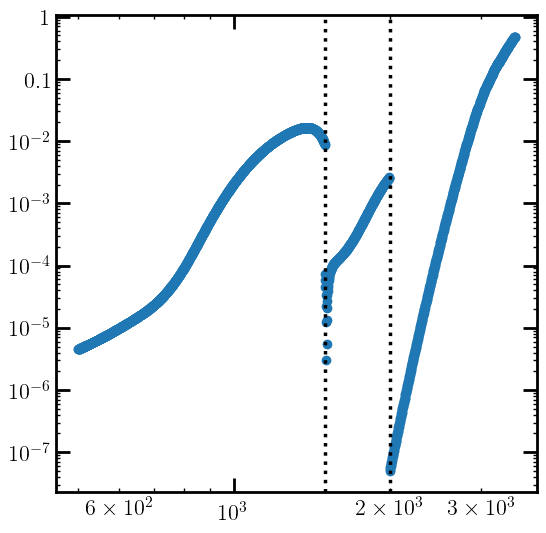

In [627]:
plt.figure()

plt.loglog()
plt.scatter(delta_dists.rs, np.abs(delta_dists.toteng()))
plt.axvline(2e3, color='k', linestyle=':')
plt.axvline(1.5e3, color='k', linestyle=':')

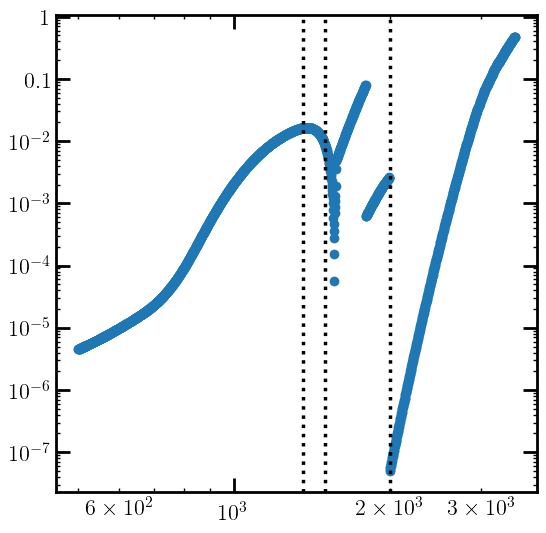

In [625]:
plt.figure()

plt.loglog()
plt.scatter(delta_dists.rs, np.abs(delta_dists.toteng()))
plt.axvline(2e3, color='k', linestyle=':')
plt.axvline(1.5e3, color='k', linestyle=':')

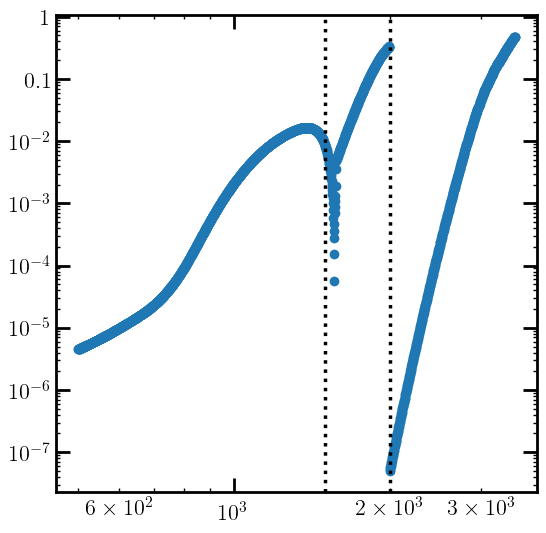

In [608]:
plt.figure()

plt.loglog()
plt.scatter(delta_dists.rs, np.abs(delta_dists.toteng()))
plt.axvline(2e3, color='k', linestyle=':')
plt.axvline(1.5e3, color='k', linestyle=':')

# plt.xscale('log')
# plt.xlim([H_engs[0]/2, H_engs[-1]*1.1])
# plt.plot(delta_dists.eng, delta_dists[1].N)
# plt.plot(delta_dists.eng, delta_dists[120].N, alpha=0.5)


In [24]:
import csv

def download_plot(file):
    with open('/Users/gregoryridgway/Desktop/Webplot_distortion/'+file+'.csv') as csvfile:
        reader = csv.reader(csvfile)
        goods = []
        for row in reader:
            goods.append([float(r) for r in row])
            
        goods = np.array(goods)

    return goods

n10_data = download_plot('n10')
n20_data = download_plot('n20')
n30_data = download_plot('n30')
jens_data = download_plot('Full_Distortion')
jens_2s = download_plot('DeltaR_2s_jens')
jens_2p = download_plot('DeltaR_2p_jens')


Text(0, 0.5, 'Intensity, $I_{\\nu}$ [J s$^{-1}$ m$^{-2}$ Hz$^{-1}$ sr$^{-1}$]')

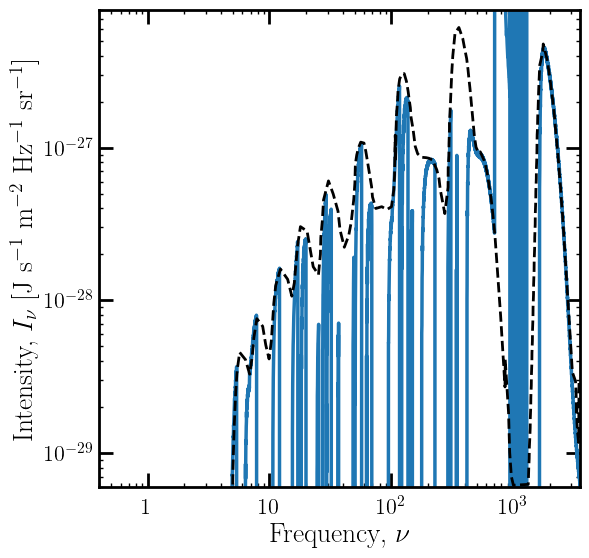

In [637]:
planck = phys.hbar * 2*np.pi
convert = phys.nB * eng * hplanck * phys.c /(4*np.pi) * phys.ele * 1e4
nu = eng/hplanck


plt.figure()
# plt.xscale('log')
plt.loglog()
# plt.axis([1e-3,1,-1.4e-7,1e-8])
plt.xlim([4e-1, 3.5e3])
plt.ylim([6e-30, 8e-27])
# plt.plot(nu_coarse[::100]/1e9, data_coarse)
plt.plot(nu/1e9, convert * distortion10.dNdE)
# plt.scatter(nu/1e9, convert * distortion20.dNdE, s=1)
# plt.scatter(nu/1e9, convert * distortion30.dNdE, s=1)

plt.plot(n10_data[:,0], n10_data[:,1], color='k', linewidth=2.0, linestyle='--')
# plt.plot(n20_data[:,0], n20_data[:,1], color='k', linewidth=1.0, linestyle=':')
# plt.plot(n30_data[:,0], n30_data[:,1], color='k', linewidth=1.2)
# plt.plot(distortion30.eng/hplanck/1e9, convert * distortion30.dNdE)

plt.xlabel(r'Frequency, $\nu$', fontsize=20)
plt.ylabel(r'Intensity, $I_{\nu}$ [J s$^{-1}$ m$^{-2}$ Hz$^{-1}$ sr$^{-1}$]', fontsize=20)

In [674]:
H_engs

array([ 0.03189722,  0.04459315,  0.06504283,  0.07649037,  0.10021413,
        0.10963598,  0.14153319,  0.16525696,  0.16620129,  0.20985011,
        0.24174733,  0.26641542,  0.30596146,  0.33145825,  0.3760514 ,
        0.40794861,  0.47216275,  0.57237688,  0.63741971,  0.66102785,
        0.68201286,  0.71391008,  0.96698931,  1.1331906 ,  1.23340473,
        1.29844756,  1.34304071,  1.37493792,  1.88865099,  2.54967884,
        2.8556403 ,  3.02184159,  3.12205572,  3.18709855,  3.2316917 ,
        3.26358892, 10.19871536, 12.08736636, 12.7483942 , 13.05435566,
       13.22055695, 13.32077109, 13.38581391, 13.43040706, 13.46230428,
       20.        ])

Text(0, 0.5, 'Intensity, $I_{\\nu}$ [J s$^{-1}$ m$^{-2}$ Hz$^{-1}$ sr$^{-1}$]')

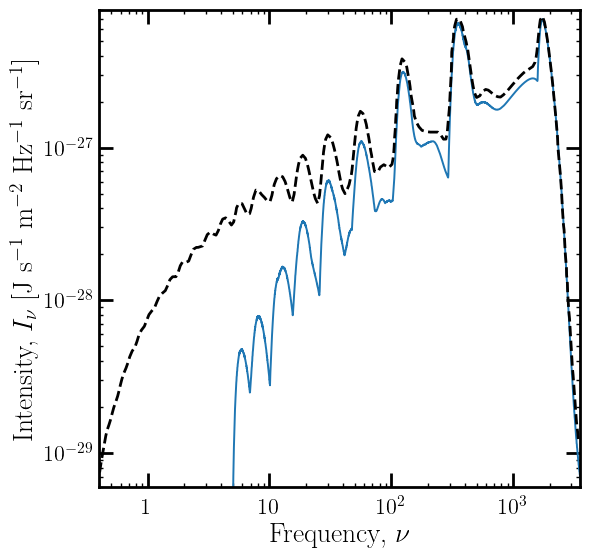

In [85]:
planck = phys.hbar * 2*np.pi
convert = phys.nB * eng * hplanck * phys.c /(4*np.pi) * phys.ele * 1e4
nu = eng/hplanck
rs_fac = 1300


plt.figure()
# plt.xscale('log')
plt.loglog()
# plt.axis([1e-3,1,-1.4e-7,1e-8])
plt.xlim([4e-1, 3.5e3])
plt.ylim([6e-30, 8e-27])
# plt.plot(nu_coarse[::100]/1e9, data_coarse)
plt.plot(nu/1e9, convert * distortion10.dNdE, linewidth=1.4)
# plt.plot(nu/1e9, convert * distortion10.dNdE*1.2, linewidth=1.4, linestyle=':', color='k')
# plt.plot(nu/1e9, convert * distortion20.dNdE, linewidth=1.4, color='C2')
# plt.plot(nu/1e9, convert * distortion30.dNdE, linewidth=1.7, color='C3')
# plt.plot(nu/1e9, convert * distortion30.dNdE, linewidth=1.7)

# # plt.axvline(-13.6*(1/3**2 - 1/2**2)/hplanck/1400/1e9, color='red', linestyle=':')
# plt.axvline(4.4/hplanck/rs_fac/1e9, color='red', linestyle=':')

# #2p-1s
# plt.axvline(13.6*(1**-2 - 2**-2)/hplanck/rs_fac/1e9, color='green', linestyle=':')

# #3p-2s
# plt.axvline(13.6*(2**-2 - 3**-2)/hplanck/rs_fac/1e9, color='green', linestyle=':')

# #4p-3s
# plt.axvline(13.6*(3**-2 - 4**-2)/hplanck/rs_fac/1e9, color='green', linestyle=':')

# plt.plot(n10_data[:,0], n10_data[:,1], color='k', linewidth=2.0, linestyle='--')
# plt.plot(n20_data[:,0], n20_data[:,1], color='k', linewidth=1.0, linestyle=':')
# plt.plot(n30_data[:,0], n30_data[:,1], color='k', linewidth=1.2)
plt.plot(jens_dist[:,0], jens_dist[:,1], color='k', linewidth=2.0, linestyle='--')
# plt.plot(distortion30.eng/hplanck/1e9, convert * distortion30.dNdE)

plt.xlabel(r'Frequency, $\nu$', fontsize=20)
plt.ylabel(r'Intensity, $I_{\nu}$ [J s$^{-1}$ m$^{-2}$ Hz$^{-1}$ sr$^{-1}$]', fontsize=20)

Text(0, 0.5, 'Intensity, $I_{\\nu}$ [J s$^{-1}$ m$^{-2}$ Hz$^{-1}$ sr$^{-1}$]')

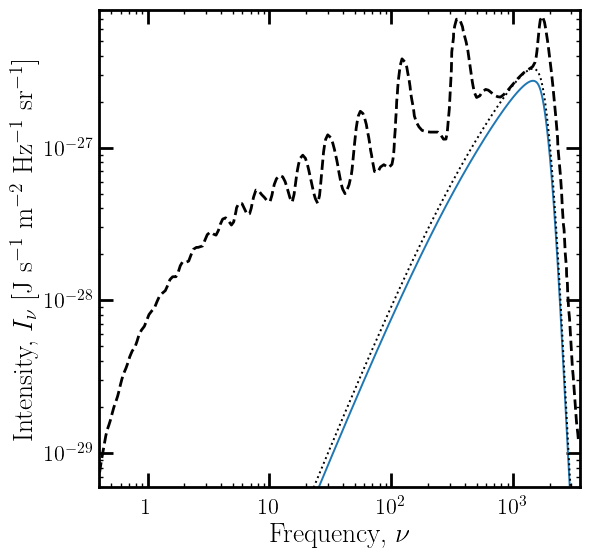

In [63]:
planck = phys.hbar * 2*np.pi
convert = phys.nB * eng * hplanck * phys.c /(4*np.pi) * phys.ele * 1e4
nu = eng/hplanck
rs_fac = 1300


plt.figure()
# plt.xscale('log')
plt.loglog()
# plt.axis([1e-3,1,-1.4e-7,1e-8])
plt.xlim([4e-1, 3.5e3])
plt.ylim([6e-30, 8e-27])
# plt.plot(nu_coarse[::100]/1e9, data_coarse)
plt.plot(nu/1e9, convert * distortion10.dNdE, linewidth=1.4)
plt.plot(nu/1e9, convert * distortion10.dNdE*1.2, linewidth=1.4, linestyle=':', color='k')
# plt.plot(nu/1e9, convert * distortion20.dNdE, linewidth=1.4, color='C2')
# plt.plot(nu/1e9, convert * distortion30.dNdE, linewidth=1.7, color='C3')
# plt.plot(nu/1e9, convert * distortion30.dNdE, linewidth=1.7)

# # plt.axvline(-13.6*(1/3**2 - 1/2**2)/hplanck/1400/1e9, color='red', linestyle=':')
# plt.axvline(4.4/hplanck/rs_fac/1e9, color='red', linestyle=':')

# #2p-1s
# plt.axvline(13.6*(1**-2 - 2**-2)/hplanck/rs_fac/1e9, color='green', linestyle=':')

# #3p-2s
# plt.axvline(13.6*(2**-2 - 3**-2)/hplanck/rs_fac/1e9, color='green', linestyle=':')

# #4p-3s
# plt.axvline(13.6*(3**-2 - 4**-2)/hplanck/rs_fac/1e9, color='green', linestyle=':')

# plt.plot(n10_data[:,0], n10_data[:,1], color='k', linewidth=2.0, linestyle='--')
# plt.plot(n20_data[:,0], n20_data[:,1], color='k', linewidth=1.0, linestyle=':')
# plt.plot(n30_data[:,0], n30_data[:,1], color='k', linewidth=1.2)
plt.plot(jens_dist[:,0], jens_dist[:,1], color='k', linewidth=2.0, linestyle='--')
# plt.plot(distortion30.eng/hplanck/1e9, convert * distortion30.dNdE)

plt.xlabel(r'Frequency, $\nu$', fontsize=20)
plt.ylabel(r'Intensity, $I_{\nu}$ [J s$^{-1}$ m$^{-2}$ Hz$^{-1}$ sr$^{-1}$]', fontsize=20)

Text(0, 0.5, 'Intensity, $I_{\\nu}$ [J s$^{-1}$ m$^{-2}$ Hz$^{-1}$ sr$^{-1}$]')

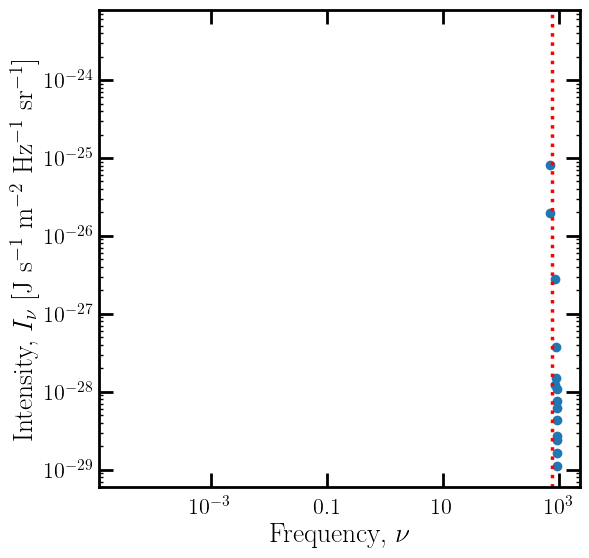

In [148]:
plt.figure()
plt.loglog()
# plt.xlim([4e-1, 3.5e3])
plt.ylim([6e-30, 8e-24])


convert = phys.nB * delta_dists.eng * hplanck * phys.c /(4*np.pi) * phys.ele * 1e4

rs_tmp = 3490
ind = sum(delta_dists.rs < rs_tmp)
# ind = -200
nu = delta_dists.eng/hplanck
plt.axvline(10.2/hplanck/3300/1e9, color='red', linestyle=':')

plt.loglog()
pos = delta_dists[ind].dNdE>0
plt.scatter(nu[pos]/1e9/rs_tmp, (convert*delta_dists[ind].dNdE)[pos], color='C0')
plt.scatter(nu[~pos]/1e9/rs_tmp, -(convert*delta_dists[ind].dNdE)[~pos], color='C3')
plt.xlabel(r'Frequency, $\nu$', fontsize=20)
plt.ylabel(r'Intensity, $I_{\nu}$ [J s$^{-1}$ m$^{-2}$ Hz$^{-1}$ sr$^{-1}$]', fontsize=20)

Text(0, 0.5, 'Intensity, $I_{\\nu}$ [J s$^{-1}$ m$^{-2}$ Hz$^{-1}$ sr$^{-1}$]')

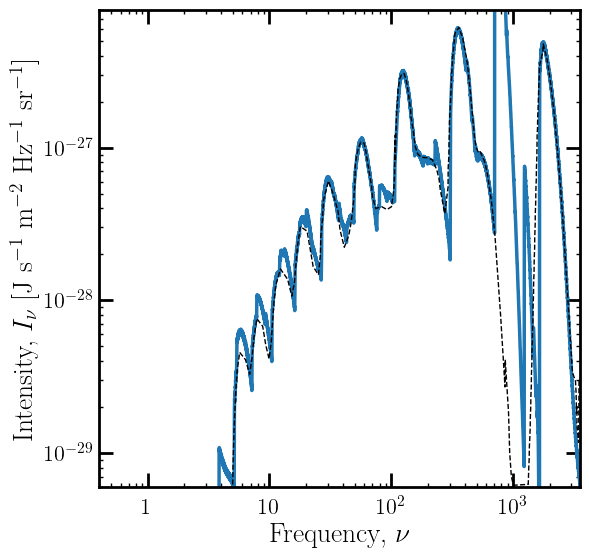

In [628]:
planck = phys.hbar * 2*np.pi
convert = phys.nB * eng * hplanck * phys.c /(4*np.pi) * phys.ele * 1e4
nu = eng/hplanck


plt.figure()
# plt.xscale('log')
plt.loglog()
# plt.axis([1e-3,1,-1.4e-7,1e-8])
plt.xlim([4e-1, 3.5e3])
plt.ylim([6e-30, 8e-27])
# plt.plot(nu_coarse[::100]/1e9, data_coarse)
plt.plot(nu/1e9, convert * distortion10.dNdE)
# plt.scatter(nu/1e9, convert * distortion20.dNdE, s=1)
# plt.scatter(nu/1e9, convert * distortion30.dNdE, s=1)

plt.plot(n10_data[:,0], n10_data[:,1], color='k', linewidth=1.0, linestyle='--')
# plt.plot(n20_data[:,0], n20_data[:,1], color='k', linewidth=1.0, linestyle=':')
# plt.plot(n30_data[:,0], n30_data[:,1], color='k', linewidth=1.2)
# plt.plot(distortion30.eng/hplanck/1e9, convert * distortion30.dNdE)

plt.xlabel(r'Frequency, $\nu$', fontsize=20)
plt.ylabel(r'Intensity, $I_{\nu}$ [J s$^{-1}$ m$^{-2}$ Hz$^{-1}$ sr$^{-1}$]', fontsize=20)

Text(0, 0.5, 'Intensity, $I_{\\nu}$ [J s$^{-1}$ m$^{-2}$ Hz$^{-1}$ sr$^{-1}$]')

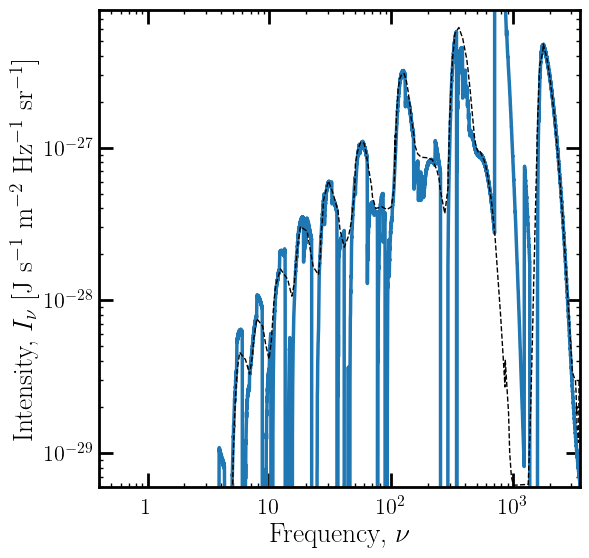

In [618]:
planck = phys.hbar * 2*np.pi
convert = phys.nB * eng * hplanck * phys.c /(4*np.pi) * phys.ele * 1e4
nu = eng/hplanck


plt.figure()
# plt.xscale('log')
plt.loglog()
# plt.axis([1e-3,1,-1.4e-7,1e-8])
plt.xlim([4e-1, 3.5e3])
plt.ylim([6e-30, 8e-27])
# plt.plot(nu_coarse[::100]/1e9, data_coarse)
plt.plot(nu/1e9, convert * distortion10.dNdE)
# plt.scatter(nu/1e9, convert * distortion20.dNdE, s=1)
# plt.scatter(nu/1e9, convert * distortion30.dNdE, s=1)

plt.plot(n10_data[:,0], n10_data[:,1], color='k', linewidth=1.0, linestyle='--')
# plt.plot(n20_data[:,0], n20_data[:,1], color='k', linewidth=1.0, linestyle=':')
# plt.plot(n30_data[:,0], n30_data[:,1], color='k', linewidth=1.2)
# plt.plot(distortion30.eng/hplanck/1e9, convert * distortion30.dNdE)

plt.xlabel(r'Frequency, $\nu$', fontsize=20)
plt.ylabel(r'Intensity, $I_{\nu}$ [J s$^{-1}$ m$^{-2}$ Hz$^{-1}$ sr$^{-1}$]', fontsize=20)

Text(0, 0.5, 'Intensity, $I_{\\nu}$ [J s$^{-1}$ m$^{-2}$ Hz$^{-1}$ sr$^{-1}$]')

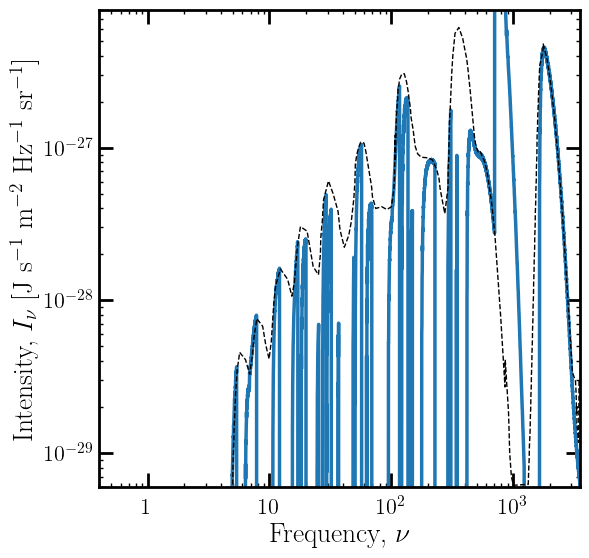

In [601]:
hplanck = phys.hbar * 2*np.pi
convert = phys.nB * eng * hplanck * phys.c /(4*np.pi) * phys.ele * 1e4
nu = eng/hplanck


plt.figure()
# plt.xscale('log')
plt.loglog()
# plt.axis([1e-3,1,-1.4e-7,1e-8])
plt.xlim([4e-1, 3.5e3])
plt.ylim([6e-30, 8e-27])
# plt.plot(nu_coarse[::100]/1e9, data_coarse)
plt.plot(nu/1e9, convert * distortion10.dNdE)
# plt.scatter(nu/1e9, convert * distortion20.dNdE, s=1)
# plt.scatter(nu/1e9, convert * distortion30.dNdE, s=1)

plt.plot(n10_data[:,0], n10_data[:,1], color='k', linewidth=1.0, linestyle='--')
# plt.plot(n20_data[:,0], n20_data[:,1], color='k', linewidth=1.0, linestyle=':')
# plt.plot(n30_data[:,0], n30_data[:,1], color='k', linewidth=1.2)
# plt.plot(distortion30.eng/hplanck/1e9, convert * distortion30.dNdE)

plt.xlabel(r'Frequency, $\nu$', fontsize=20)
plt.ylabel(r'Intensity, $I_{\nu}$ [J s$^{-1}$ m$^{-2}$ Hz$^{-1}$ sr$^{-1}$]', fontsize=20)

$$
4\mathcal{C} \beta_B x_{1s} e^{-E_\alpha /T} = \beta_{MLA}
$$

In [ ]:
ion_TLA = np.zeros(length)
ion_Hongwan_noSE = np.zeros(length)
ion_Hongwan = np.zeros(length)
# nmax = 20

for i,Tr in enumerate(tqdm(rs_vec)):
    rs = rs_vec[i]
    x2 = x2_vec[i]
    Tr = Tr_vec[i]
    
    ion_TLA[i] = phys.beta_ion(Tr,'HI') * x2
    
    #Detailed Balance factor
    lam_T = hc/np.sqrt(2*np.pi*phys.mu_ep*Tr)
    db_fac = np.exp(phys.rydberg/4 / Tr) * lam_T**3 * 4
    ion_Hongwan_noSE[i] = bf.alpha_B(Tr, T_r=Tr, stimulated_emission=False, f_gamma=None, n=nmax)/db_fac * x2
    
    ion_Hongwan[i] = bf.beta_B(Tr,nmax) * x2
    
#     print(rs, " Done")

/var/folders/kq/gkzlnb6576x8mxsf32v72_y00000gn/T/ipykernel_4224/37483958.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i,Tr in enumerate(tqdm(rs_vec)):


  0%|          | 0/355 [00:00<?, ?it/s]

/var/folders/kq/gkzlnb6576x8mxsf32v72_y00000gn/T/ipykernel_4224/37483958.py:15: RuntimeWarning: overflow encountered in exp
  db_fac = np.exp(phys.rydberg/4 / Tr) * lam_T**3 * 4


/var/folders/kq/gkzlnb6576x8mxsf32v72_y00000gn/T/ipykernel_4224/976435076.py:22: RuntimeWarning: divide by zero encountered in true_divide
  axarr[1].plot(rs_vec[rs_vec>700], (beta_MLA/ion_TLA-1)[rs_vec>700],


Text(0.5, 1.0, 'Residuals')

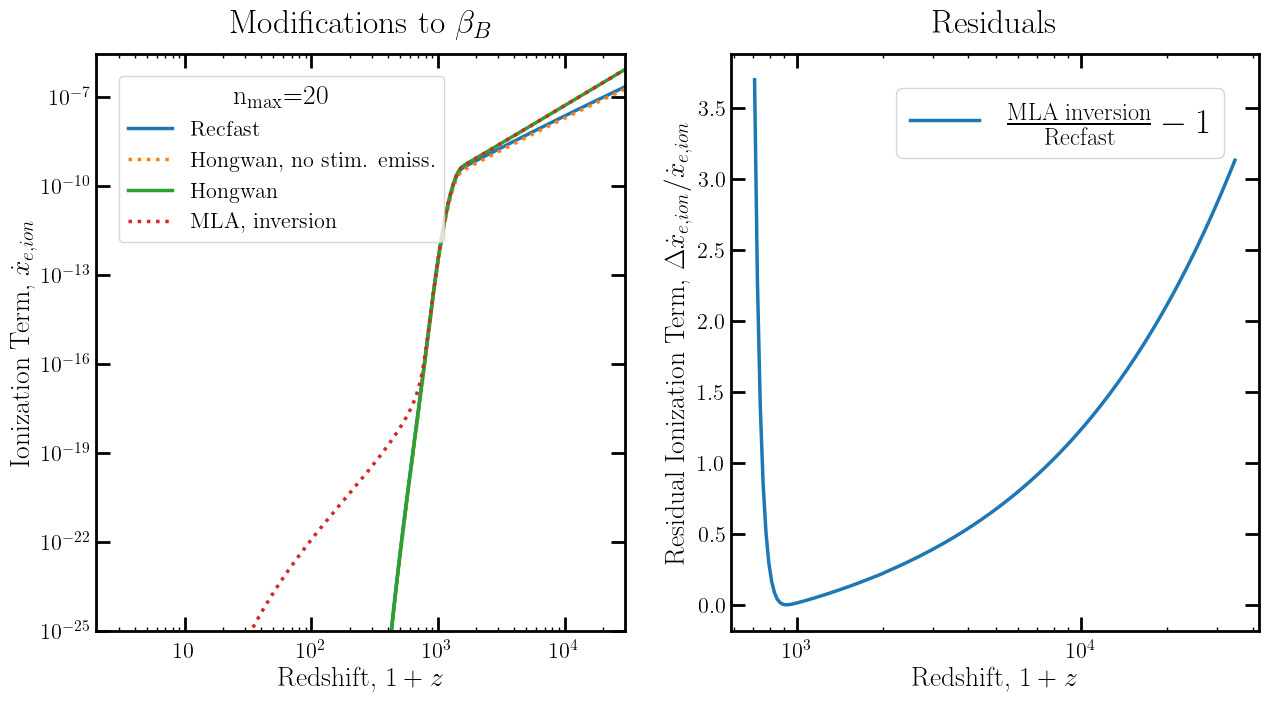

In [ ]:
fig, axarr = plt.subplots(1,2, figsize=(2*7.5, 7.5))

axarr[0].loglog()
axarr[0].axis([2,3e4,1e-25,3e-6])
# plt.axis([5e2,2e4,1e-17,10])

axarr[0].plot(rs_vec,ion_TLA, label='Recfast')
axarr[0].plot(rs_vec,ion_Hongwan_noSE, label='Hongwan, no stim. emiss.', linestyle=':')
axarr[0].plot(rs_vec,ion_Hongwan, label='Hongwan')
axarr[0].plot(rs_vec,beta_MLA, label='MLA, inversion', linestyle=':')

axarr[0].legend(fontsize=12)
axarr[0].set_xlabel(r'Redshift, $1+z$', fontsize=20)
axarr[0].set_ylabel(r'Ionization Term, $\dot{x}_{e,ion}$', fontsize=20)
axarr[0].legend(title=r'$\mathrm{n_{max}}$='+str(nmax))

axarr[0].set_title(r'Modifications to $\beta_B$')



axarr[1].set_xscale('log')
axarr[1].plot(rs_vec[rs_vec>700], (beta_MLA/ion_TLA-1)[rs_vec>700], 
              label=r'$\frac{\mathrm{MLA \; inversion}}{\mathrm{Recfast}}-1$')

axarr[1].legend(fontsize=25)
axarr[1].set_xlabel(r'Redshift, $1+z$', fontsize=20)
axarr[1].set_ylabel(r'Residual Ionization Term, '+
                    r'$\Delta \dot{x}_{e,ion}/\dot{x}_{e,ion}$', fontsize=20)

axarr[1].set_title(r'Residuals')

Text(0.5, 1.0, 'Modifications to $\\alpha_B$')

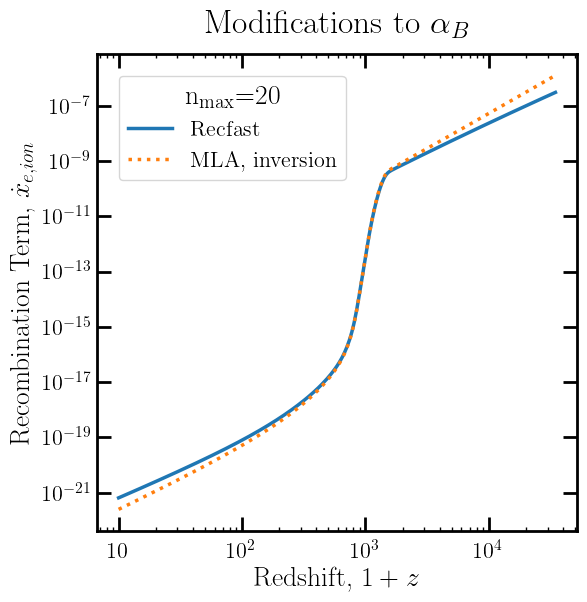

In [ ]:
plt.figure()
plt.loglog()
# plt.axis([2,3e4,1e-25,3e-6])
# plt.axis([5e2,2e4,1e-17,10])

plt.plot(rs_vec,phys.alpha_recomb(Tm_vec,'HI')*nH_vec*xe_vec**2, label='Recfast')
# plt.plot(rs_vec,ion_Hongwan_noSE, label='DH, no stim. emiss.')
# plt.plot(rs_vec,ion_Hongwan, label='DH')
plt.plot(rs_vec,alpha_MLA * xe_vec**2 * nH_vec, label='MLA, inversion', linestyle=':')

plt.legend()
plt.xlabel(r'Redshift, $1+z$', fontsize=20)
plt.ylabel(r'Recombination Term, $\dot{x}_{e,ion}$', fontsize=20)
plt.legend(title=r'$\mathrm{n_{max}}$='+str(nmax))

plt.title(r'Modifications to $\alpha_B$')

### Understanding the output Distortion

### Recovering the TLA Assumptions

Text(0.5, 1.0, 'Testing the TLA Assumptions')

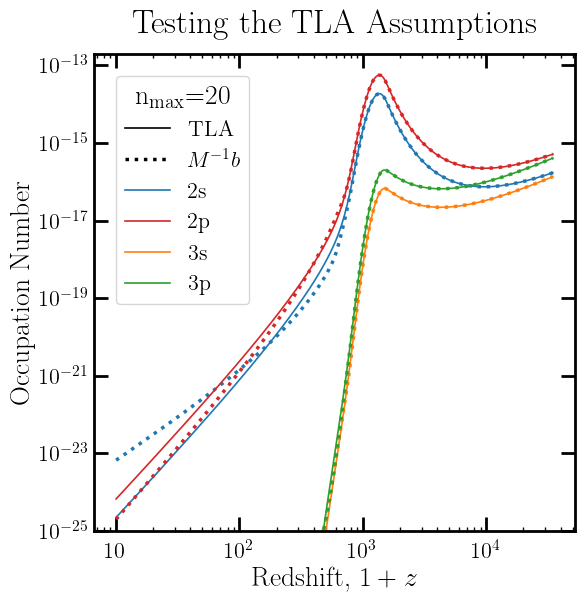

In [117]:
plt.figure()
plt.loglog()
plt.ylim([1e-25,2e-13])

x2s_vec = x2_vec/4

# plt.plot(rs_vec, xe_vec*1e-13, label=r'$x_e \times 10^{-13}$', color='k', linewidth=1.0)
# plt.plot(rs_vec, Tm_vec*1e-14, label=r'$x_e \times 10^{-13}$', color='k', linewidth=1.0)

lw=1.2

plt.plot(rs_vec, np.ones_like(rs_vec), label=r'TLA', color='k', linewidth=lw)
plt.plot(rs_vec, np.ones_like(rs_vec), label=r'$M^{-1} b$', color='k', linestyle=':')

plt.plot(rs_vec, x2s_vec, label='2s', color='C0', linewidth=lw)
plt.plot(rs_vec[::skip], x_vec[::skip,0], color='C0', linestyle=':')

plt.plot(rs_vec, 3*x2s_vec, label='2p', color='C3', linewidth=lw)
plt.plot(rs_vec[::skip], x_vec[::skip,1], color='C3', linestyle=':')

plt.plot(rs_vec, g_nl(0)*x2s_vec * np.exp((E(3)-E(2))/Tr_vec), label='3s', color='C1', linewidth=lw)
plt.plot(rs_vec[::skip], x_vec[::skip,2], color='C1', linestyle=':')

plt.plot(rs_vec, g_nl(1)*x2s_vec * np.exp((E(3)-E(2))/Tr_vec), label='3p', color='C2', linewidth=lw)
plt.plot(rs_vec[::skip], x_vec[::skip,3], color='C2', linestyle=':')

# plt.plot(rs_vec, g_nl(2)*x2s_vec * np.exp((E(3)-E(2))/Tr_vec), label='3d', color='C4', linewidth=lw)
# plt.plot(rs_vec[::skip], x_vec[::skip,4], color='C4', linestyle=':')

# plt.plot(rs_vec, g(1)*x2s_vec * np.exp((E(4)-E(2))/Tr_vec), label='4p', color='C3', linestyle=':')
# plt.plot(rs_vec, g(1)*x2s_vec * np.exp((E(5)-E(2))/Tr_vec), label='5p', color='C3', linestyle=':')

plt.xlabel(r'Redshift, $1+z$', fontsize=20)
plt.ylabel(r'Occupation Number', fontsize=20)
plt.legend(title=r'$\mathrm{n_{max}}$='+str(nmax))

plt.title(r'Testing the TLA Assumptions')

Text(0.5, 1.0, 'Testing the TLA Assumptions')

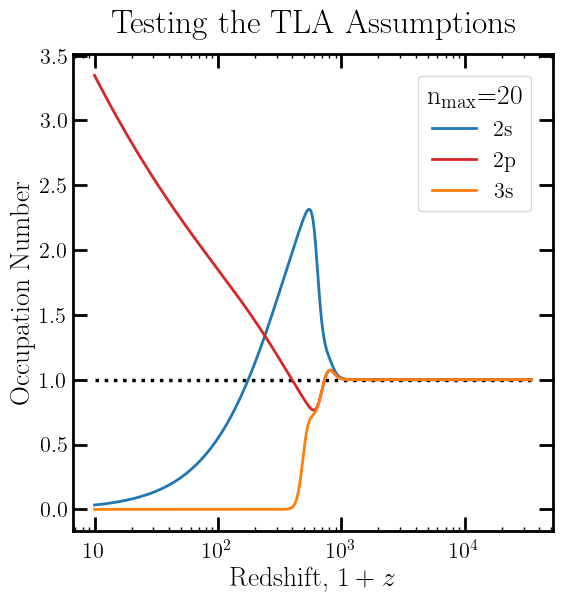

In [118]:
plt.figure()
# plt.loglog()
plt.xscale('log')
# plt.ylim([1e-25,2e-13])

x2s_vec = x2_vec/4

# plt.plot(rs_vec, xe_vec*1e-13, label=r'$x_e \times 10^{-13}$', color='k', linewidth=1.0)
# plt.plot(rs_vec, Tm_vec*1e-14, label=r'$x_e \times 10^{-13}$', color='k', linewidth=1.0)

lw=2.0

# plt.plot(rs_vec, np.ones_like(rs_vec), label=r'TLA', color='k', linewidth=lw)
plt.plot(rs_vec, np.ones_like(rs_vec), color='k', linestyle=':')

plt.plot(rs_vec, x2s_vec/x_vec[:,0], label='2s', color='C0', linewidth=lw)
plt.plot(rs_vec, 3*x2s_vec/x_vec[:,1], label='2p', color='C3', linewidth=lw)
plt.plot(rs_vec, g_nl(0)*x2s_vec * np.exp((E(3)-E(2))/Tr_vec)/x_vec[:,2], 
         label='3s', color='C1', linewidth=lw)


# plt.plot(rs_vec, g_nl(0)*x2s_vec * np.exp((E(3)-E(2))/Tr_vec), label='3s', color='C1', linewidth=lw)
# plt.plot(rs_vec[::skip], x_vec[::skip,2], color='C1', linestyle=':')

# plt.plot(rs_vec, g_nl(1)*x2s_vec * np.exp((E(3)-E(2))/Tr_vec), label='3p', color='C2', linewidth=lw)
# plt.plot(rs_vec[::skip], x_vec[::skip,3], color='C2', linestyle=':')

# plt.plot(rs_vec, g_nl(2)*x2s_vec * np.exp((E(3)-E(2))/Tr_vec), label='3d', color='C4', linewidth=lw)
# plt.plot(rs_vec[::skip], x_vec[::skip,4], color='C4', linestyle=':')

# plt.plot(rs_vec, g(1)*x2s_vec * np.exp((E(4)-E(2))/Tr_vec), label='4p', color='C3', linestyle=':')
# plt.plot(rs_vec, g(1)*x2s_vec * np.exp((E(5)-E(2))/Tr_vec), label='5p', color='C3', linestyle=':')

plt.xlabel(r'Redshift, $1+z$', fontsize=20)
plt.ylabel(r'Occupation Number', fontsize=20)
plt.legend(title=r'$\mathrm{n_{max}}$='+str(nmax))

plt.title(r'Testing the TLA Assumptions')

## Hyrec Comparison

### Generate $\alpha(T_m,T_r)$ and $\beta(T_r, x_e)$

In [107]:
%autoreload
delta = .005
rs_vec  = 10**np.arange(np.log10(201),np.log10(3e3), delta) #np.linspace(99,3001,200)
Tr_vec  = phys.TCMB(rs_vec)
Tm_vec  = phys.Tm_std(rs_vec)

length  = len(rs_vec)

xHII_std = interp1d(fudge['rs'], fudge['x'][:,0], fill_value="extrapolate")

xe_vec  = xHII_std(rs_vec)
x1s_vec = phys.xHI_std(rs_vec)
nH_vec  = phys.nH * rs_vec**3

tau_vec = atomic.tau_np_1s(2,rs_vec)
x2s_vec = atomic.x2s_steady_state(rs_vec, Tr_vec, Tm_vec, xe_vec, x1s_vec, tau_vec)
x2_vec  = 4*x2s_vec

In [137]:
nmax=100

num_states = int(nmax*(nmax+1)/2)
ident = np.identity(num_states-1)
R = atomic.populate_radial(nmax)

states_n = np.concatenate([list(map(int,k*np.ones(k))) for k in range(1,nmax+1,1)])
states_l = np.concatenate([np.arange(k) for k in range(1,nmax+1)])
exc_states = np.transpose([states_n,states_l])[1:]

x_vec = np.zeros((length,num_states-1))
x_lte = np.zeros(num_states) #equilibrium solution
x_lte[0] = x1s_vec[0]

beta_MLA = np.zeros(length)
alpha_MLA = np.zeros(length)

new_switch = True
Hongwan = False

for i in tqdm(np.arange(length)):
    rs = rs_vec[i]
    xe  = xe_vec[i]
    x1s = x1s_vec[i]
    
    nH  = nH_vec[i]
    Tr = Tr_vec[i]
    Tm = Tm_vec[i]
    

    #Get the transition rates
    BB = atomic.populate_bound_bound(nmax, Tr, R, Delta_f=Delta_f)
    k2_tab, g = atomic.populate_k2_and_g(nmax, Tm)
    alpha = atomic.populate_alpha(Tm, Tr, nmax, k2_tab, g, Delta_f=Delta_f, new_switch=new_switch)
    beta = atomic.populate_beta(Tm, Tr, nmax, k2_tab, g, Delta_f=Delta_f, new_switch=new_switch)

    if Hongwan:
        beta_MLA[i] = bf.beta_B(Tr,nmax) * 4*x2s_vec[i]
        alpha_MLA[i] = np.sum(alpha)-alpha[1][0]
    else:
        #Include sobolev optical depth
        for n in range(2,nmax+1):
            BB['dn'][n][1][1] *= atomic.p_np_1s(n, rs, xHI=x1s)
            BB['up'][1][n][0] *= atomic.p_np_1s(n, rs, xHI=x1s)

        ### Build transition probability matrix, P_ij (i,j of excited states)
        mat = np.zeros((num_states, num_states))
        b = np.zeros(num_states)
        for nl in np.arange(num_states):
    #         print(rs, xe**2 * alpha[n][l]*nH)
            # Find indices for possible states to transition to (l must change by 1)
            # Get the rates for transitioning to those states, as well as total rate

            n = states_n[nl]
            l = states_l[nl]
            x_lte[nl] = g_nl(l) * np.exp((E(n)-E(1))/Tr) * x1s
            tot_rate = np.sum(BB['dn'][n,:,l]) + np.sum(BB['up'][n,:,l]) + beta[n][l]
            
            # Construct the matrix
            if l!= 0:
                mat[nl,states_l == l-1] = BB['up'][l:,n,l-1]/tot_rate
                
            if l!= nmax-1:
                mat[nl,states_l == l+1] = BB['dn'][l+2:,n,l+1]/tot_rate

            # Special 2s->1s transition
            if nl == 0:
                mat[0][1] = BB['dn'][2][1][0]/ tot_rate
            if nl == 1:
                #Detalied Balance
                mat[1][0] = BB['dn'][2][1][0]*np.exp((E(2)-E(1))/Tr) / tot_rate
                

            # Construct the inhomogeneous term
            b[nl] += xe**2 * nH * alpha[n][l]
            if l==1:
                b[nl] += x1s*BB['up'][1, n, 0]
            elif nl==1:
                # 1s to 2s transition from detailed balance
                b[nl] += x1s*BB['dn'][2][1][0]*np.exp(-phys.lya_eng/Tr)
                
            b[nl] /= tot_rate

        #Probability matrix for only the excited states
        M = ident - mat[1:,1:]
        
        x_vec[i] = np.linalg.solve(M,b[1:])
        x_full = np.append(1-np.sum(x_vec[i])-xe, x_vec[i])
        
        for nl in np.arange(num_states):
            n, l = states_n[nl], states_l[nl]
            if nl > 0:
                beta_MLA[i]  += x_full[nl] * beta[n][l]
                alpha_MLA[i] += alpha[n][l] #* xe**2 * nH


MLA_funcs =  [
    interp1d(rs_vec, alpha_MLA, fill_value="extrapolate"), 
    interp1d(np.log(rs_vec), np.log(beta_MLA), fill_value="extrapolate")
]

/var/folders/kq/gkzlnb6576x8mxsf32v72_y00000gn/T/ipykernel_70957/816684963.py:21: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(np.arange(length)):


  0%|          | 0/235 [00:00<?, ?it/s]

In [151]:
pickle.dump(MLA_funcs, open('/Users/gregoryridgway/Desktop/Data/MLA_funcs_100.p','wb'))

### Try to reproduce Hyrec Fig. 3

In [56]:
%autoreload
mDM = 3e10
# sigmav = xsec_bound_elec_CMB(mDM,'swave')
lifetime=1e50
species = 'phot'
DM_process = 'decay'
string = str(int(np.floor(np.log10(mDM))))
start_rs = 3e3
end_rs = 200

In [203]:
nmax

100

In [204]:
%autoreload
hyrec_tmp = main.evolve(
    DM_process=DM_process, mDM=mDM,
    lifetime=lifetime,
    primary=species+'_delta',
    start_rs = start_rs,
    coarsen_factor=1, backreaction=False, distort=True,
#     struct_boost=struct_boost,
#     helium_TLA=False,
    nmax = nmax,
    end_rs=end_rs,
    rtol=1e-4,
    MLA_funcs = None
)

  0%|          | 0/2709.0 [00:00<?, ?it/s]

TypeError: abscissa must be ordered in increasing energy.

In [50]:
%autoreload
fudge = main.evolve(
    DM_process=DM_process, mDM=mDM,
    lifetime=lifetime,
    primary=species+'_delta',
    start_rs = start_rs,
    coarsen_factor=16, backreaction=False, 
    distort=False, fudge=True,
    end_rs=end_rs
)

****** Loading transfer functions... ******
    for propagating photons...   Done!
    for low-energy photons...  Done!
    for low-energy electrons...  Done!
    for high-energy deposition...  Done!
    for total upscattered CMB energy rate...  Done!
****** Loading complete! ******
****** Loading transfer functions... ******
    for inverse Compton (Thomson)...  Done!
    for inverse Compton (relativistic)...  Done!
    for inverse Compton (energy loss)...  Done!
****** Loading complete! ******


  0%|          | 0/170.0 [00:00<?, ?it/s]

In [185]:
%autoreload
baseline = main.evolve(
    DM_process=DM_process, mDM=mDM,
    lifetime=lifetime,
    primary=species+'_delta',
    start_rs = start_rs,
    coarsen_factor=16, backreaction=False, 
    distort=False, fudge=False,
    end_rs=end_rs
)

  0%|          | 0/170.0 [00:00<?, ?it/s]

In [52]:
import csv

with open('/Users/gregoryridgway/Desktop/Webplot Digitizer/DHv2/EMLA.csv') as csvfile:
    reader = csv.reader(csvfile)
    EMLA_data = []
    for row in reader:
        EMLA_data.append([float(r) for r in row])
        
    EMLA_data = np.array(EMLA_data)
    
with open('/Users/gregoryridgway/Desktop/Webplot Digitizer/DHv2/Recfast.csv') as csvfile:
    reader = csv.reader(csvfile)
    Rec_data = []
    for row in reader:
        Rec_data.append([float(r) for r in row])
        
    Rec_data = np.array(Rec_data)

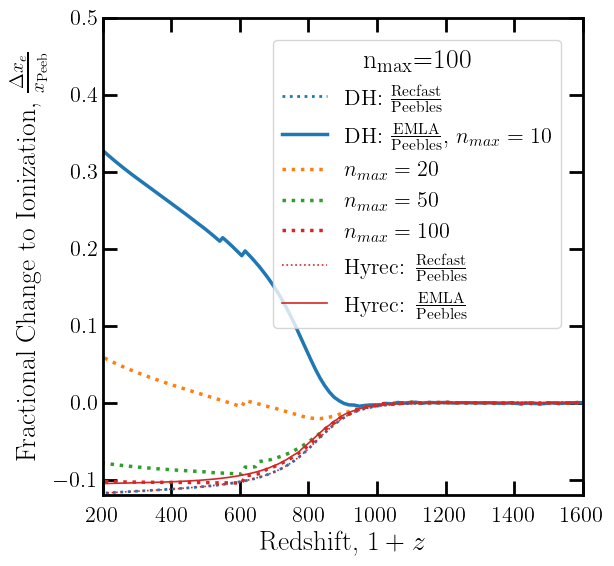

In [142]:
plt.figure()
# plt.loglog()
# plt.xscale('log')
plt.axis([200,1600, -.12,.5])
# plt.plot(baseline['rs'], baseline['x'][:,0])
# plt.plot(baseline['rs'], phys.xHII_std(baseline['rs']))
plt.plot(fudge['rs'], fudge['x'][:,0]/baseline['x'][:,0]-1, 
         color='C0', linestyle=':', linewidth = 2.0, 
         label=r'DH: $\frac{\mathrm{Recfast}}{\mathrm{Peebles}}$')
# plt.plot(fudge['rs'], phys.xHII_std(fudge['rs'])/baseline['x'][:,0]-1, 
#          color='C0', linestyle=':', linewidth = 2.0, 
#          label=r'DH: $\frac{\mathrm{Recfast}}{\mathrm{Peebles}}$')

plt.plot(hyrec_test10['rs'], hyrec_test10['x'][:,0]/baseline['x'][:,0]-1, 
         label=r'DH: $\frac{\mathrm{EMLA}}{\mathrm{Peebles}}$, $n_{max}=10$')
plt.plot(hyrec_test20['rs'], hyrec_test20['x'][:,0]/baseline['x'][:,0]-1, 
         label=r'$n_{max}=20$', linestyle=':')
# plt.plot(hyrec_testfine['rs'], hyrec_testfine['x'][:,0]/baseline['x'][:,0]-1, 
#          label=r'fine interp', linestyle=':')
plt.plot(hyrec50['rs'], hyrec50['x'][:,0]/baseline['x'][:,0]-1, 
         label=r'$n_{max}=50$', linestyle=':')
plt.plot(hyrec100['rs'], hyrec100['x'][:,0]/baseline['x'][:,0]-1, 
         label=r'$n_{max}=100$', linestyle=':')
# plt.plot(hyrec10_principled['rs'], hyrec10_principled['x'][:,0]/baseline['x'][:,0]-1, 
#          label=r'$n_{max}=50$', linestyle=':')

lw = 1.2
plt.plot(Rec_data[:,0], Rec_data[:,1], color='C3', 
         linewidth = lw, linestyle = ':', 
         label=r'Hyrec: $\frac{\mathrm{Recfast}}{\mathrm{Peebles}}$')
plt.plot(EMLA_data[:,0], EMLA_data[:,1], color='C3', 
         linewidth = lw, linestyle = 'solid', 
         label=r'Hyrec: $\frac{\mathrm{EMLA}}{\mathrm{Peebles}}$')

plt.xlabel(r'Redshift, $1+z$', fontsize=20)
plt.ylabel(r'Fractional Change to Ionization, $\frac{\Delta x_e}{x_{\mathrm{Peeb}}}$', fontsize=20)
# plt.ylabel(r'Occupation Number', fontsize=20)
plt.legend(title=r'$\mathrm{n_{max}}$='+str(nmax))

# plt.title(r'Testing the TLA Assumptions')

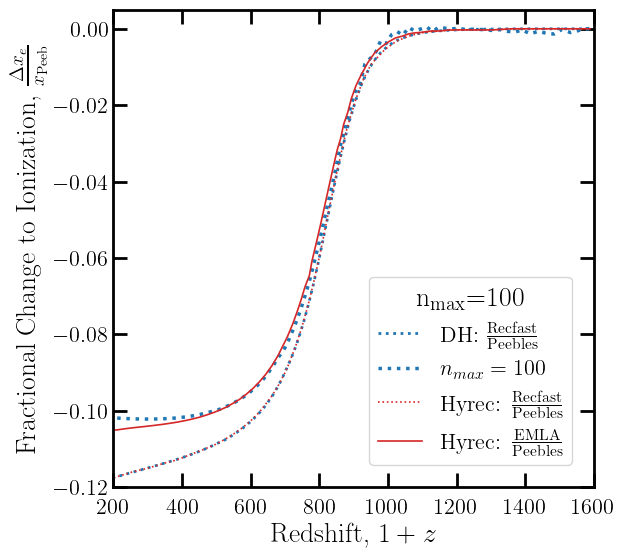

In [207]:
plt.figure()
# plt.loglog()
# plt.xscale('log')
plt.axis([200,1600, -.12,.005])
# plt.plot(baseline['rs'], baseline['x'][:,0])
# plt.plot(baseline['rs'], phys.xHII_std(baseline['rs']))
plt.plot(fudge['rs'], fudge['x'][:,0]/baseline['x'][:,0]-1, 
         color='C0', linestyle=':', linewidth = 2.0, 
         label=r'DH: $\frac{\mathrm{Recfast}}{\mathrm{Peebles}}$')

# tmp = len(hyrec_tmp['x'][::16,0])
# plt.plot(hyrec_tmp['rs'][::16], hyrec_tmp['x'][::16,0]/baseline['x'][:tmp,0]-1, 
#          label=r'$n_{max}=100$', linestyle=':')

plt.plot(hyrec_success['rs'], hyrec_success['x'][:,0]/baseline['x'][:,0]-1, 
         label=r'$n_{max}=100$', linestyle=':')

lw = 1.2
plt.plot(Rec_data[:,0], Rec_data[:,1], color='C3', 
         linewidth = lw, linestyle = ':', 
         label=r'Hyrec: $\frac{\mathrm{Recfast}}{\mathrm{Peebles}}$')
plt.plot(EMLA_data[:,0], EMLA_data[:,1], color='C3', 
         linewidth = lw, linestyle = 'solid', 
         label=r'Hyrec: $\frac{\mathrm{EMLA}}{\mathrm{Peebles}}$')

plt.xlabel(r'Redshift, $1+z$', fontsize=20)
plt.ylabel(r'Fractional Change to Ionization, $\frac{\Delta x_e}{x_{\mathrm{Peeb}}}$', fontsize=20)
# plt.ylabel(r'Occupation Number', fontsize=20)
plt.legend(title=r'$\mathrm{n_{max}}$='+str(nmax))

# plt.title(r'Testing the TLA Assumptions')

Two mysteries to be solved:
1. Why is linear interpolation so bad?  alpha and beta vs rs look linear.  Plot the main.evolve interpolation against the above plots.
2. What's going on with the jagged features in the $\Delta x_e$ plot? (tolerance issue in odesolver)

Text(0, 0.5, 'Redshift, $1+z$')

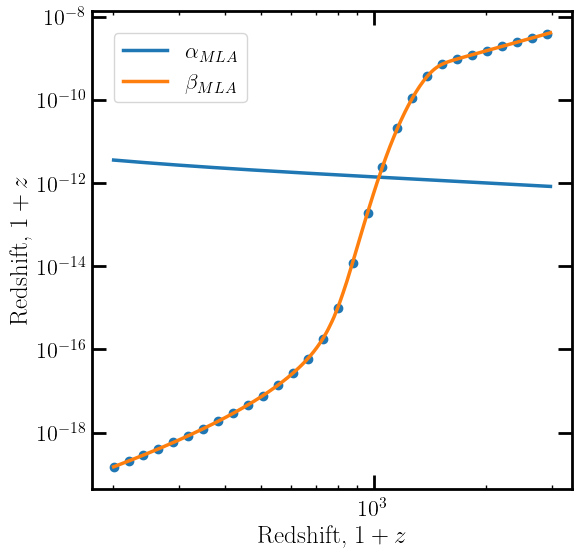

In [147]:
plt.figure()
plt.loglog()
plt.plot(rs_vec, MLA_funcs[0](rs_vec), label=r'$\alpha_{MLA}$')
plt.plot(rs_vec, np.exp(MLA_funcs[1](np.log(rs_vec))), label=r'$\beta_{MLA}$')
plt.scatter(rs_vec[::8], np.exp(MLA_funcs[1](np.log(rs_vec[::8]))))

plt.legend()
plt.xlabel(r'Redshift, $1+z$')
plt.ylabel(r'Redshift, $1+z$')

### Maintain Plots

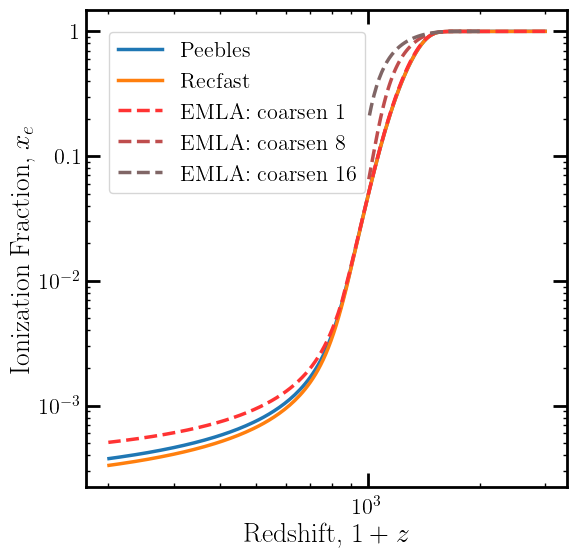

In [299]:
plt.figure()
plt.loglog()
# plt.xlim([1.56e3,3e3])
# plt.axis([1.3e3,2e3,1e-2/5,1e-2*5])
plt.plot(baseline['rs'], baseline['x'][:,0], label='Peebles')
plt.plot(fudge['rs'], fudge['x'][:,0], label='Recfast')
plt.plot(hyrec_test['rs'], hyrec_test['x'][:,0], 
         color=(1.0,0.2,0.2), linestyle='--', label='EMLA: coarsen 1')
plt.plot(hyrec_test_coarse8['rs'], hyrec_test_coarse8['x'][:,0], 
         color=(0.75,0.3,0.3), linestyle='--', label='EMLA: coarsen 8')
plt.plot(hyrec_test_coarse16['rs'], hyrec_test_coarse16['x'][:,0], 
         color=(0.5,0.4,0.4), linestyle='--', label='EMLA: coarsen 16')

plt.xlabel(r'Redshift, $1+z$', fontsize=20)
plt.ylabel(r'Ionization Fraction, $x_e$', fontsize=20)
plt.legend()

For the Recfast comparison:
- We have to be very careful about where the fudge factors are, since there's one explicitly in $\alpha$, one implicitly in $\beta$ since we calculate it using detailed balance on $\alpha$, and one in $\mathcal{C}$ since it uses $\beta$.  Once all of these are accounted for we get agreement, otherwise we don't.
- We must use a fudge factor of 1.14 to compare to Fig 3 of Hyrec, not our default of 1.125

In [38]:
import csv

with open('/Users/gregoryridgway/Desktop/Webplot Digitizer/DHv2/EMLA.csv') as csvfile:
    reader = csv.reader(csvfile)
    EMLA_data = []
    for row in reader:
        EMLA_data.append([float(r) for r in row])
        
    EMLA_data = np.array(EMLA_data)
    
with open('/Users/gregoryridgway/Desktop/Webplot Digitizer/DHv2/Recfast.csv') as csvfile:
    reader = csv.reader(csvfile)
    Rec_data = []
    for row in reader:
        Rec_data.append([float(r) for r in row])
        
    Rec_data = np.array(Rec_data)

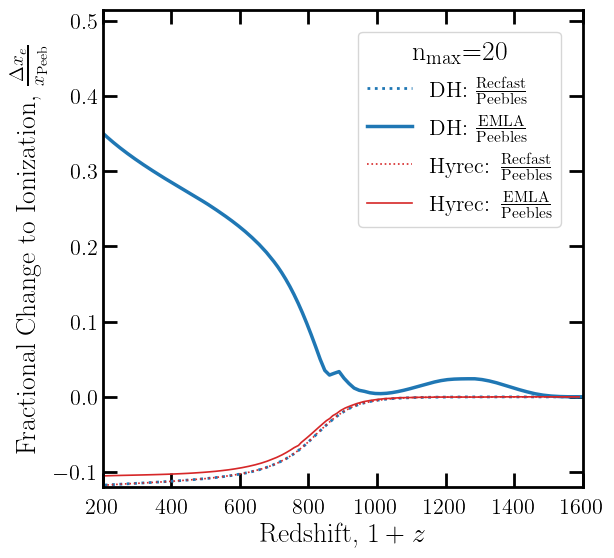

In [304]:
plt.figure()
# plt.loglog()
# plt.xscale('log')
plt.axis([200,1600, -.12,.515])
# plt.plot(baseline['rs'], baseline['x'][:,0])
# plt.plot(baseline['rs'], phys.xHII_std(baseline['rs']))
plt.plot(fudge['rs'], fudge['x'][:,0]/baseline['x'][:,0]-1, 
         color='C0', linestyle=':', linewidth = 2.0, 
         label=r'DH: $\frac{\mathrm{Recfast}}{\mathrm{Peebles}}$')
plt.plot(hyrec_test['rs'][::16], hyrec_test['x'][::16,0]/baseline['x'][:,0]-1, 
         label=r'DH: $\frac{\mathrm{EMLA}}{\mathrm{Peebles}}$')

lw = 1.2
plt.plot(Rec_data[:,0], Rec_data[:,1], color='C3', 
         linewidth = lw, linestyle = ':', 
         label=r'Hyrec: $\frac{\mathrm{Recfast}}{\mathrm{Peebles}}$')
plt.plot(EMLA_data[:,0], EMLA_data[:,1], color='C3', 
         linewidth = lw, linestyle = 'solid', 
         label=r'Hyrec: $\frac{\mathrm{EMLA}}{\mathrm{Peebles}}$')

plt.xlabel(r'Redshift, $1+z$', fontsize=20)
plt.ylabel(r'Fractional Change to Ionization, $\frac{\Delta x_e}{x_{\mathrm{Peeb}}}$', fontsize=20)
# plt.ylabel(r'Occupation Number', fontsize=20)
plt.legend(title=r'$\mathrm{n_{max}}$='+str(nmax))

# plt.title(r'Testing the TLA Assumptions')

## Trying to fix the ODE solver

In [40]:
from scipy.integrate import odeint

In [41]:
def compton_cooling_rate(xHII, T_m, rs):
    xe = xHII

    return (
        4 * phys.thomson_xsec * 4 * phys.stefboltz / phys.me
        * xe * phys.nH*rs**3 * (phys.TCMB(rs) - T_m)
        * phys.TCMB(rs)**4
    )

In [198]:
MLA_switch = False

if not MLA_switch:
    def beta_tmp(*args):
        rs, xe, Tm = args

        tau = atomic.tau_np_1s(2,rs)
        x2s = atomic.x2s_steady_state(rs, phys.TCMB(rs), Tm, xe, 1-xe, tau)
        x2  = 4*x2s
        beta_ion = phys.beta_ion(Tm, 'HI')

        return beta_ion * x2

    def alpha_tmp(*args):
        Tm, = args
        return phys.alpha_recomb(Tm, 'HI')
    
else:
    kind='linear'
    
    alpha_tmp = interp1d(rs_vec, alpha_MLA, kind=kind, fill_value='extrapolate')
    beta_tmp  = interp1d(rs_vec, beta_MLA, kind=kind)

Try Saha, then TLA, then MLA

In [137]:
import warnings

rs_div = 1.6e3

def tmp_tla(rs_vec, init, alpha_tmp, beta_tmp, mxstep=1000, rtol=1e-3):
    
    def xHII(yHII):
        return 0.5 + 0.5*np.tanh(yHII)

    def derivs(rs, var):
        nH = phys.nH*rs**3

        def dlogT_dz(yHII, log_T_m, rs):

            T_m, xe = np.exp(log_T_m), xHII(yHII)
            xHI = 1 - xHII(yHII)
            
            xe = phys.xHII_std(rs)

            adiabatic_cooling_rate = 2 * T_m/rs

            return 1 / T_m * adiabatic_cooling_rate + 1 / T_m * (
                phys.dtdz(rs)*(
                    compton_cooling_rate(
                        xHII(yHII), T_m, rs
                    )
                )
            )/ (3/2 * nH * (1 + phys.chi + xe))

        def dyHII_dz(yHII, log_T_m, rs):

            T_m, xe = np.exp(log_T_m), xHII(yHII)

            if 1 - xHII(yHII) < 1e-6 and rs < 100:
                return 0

            if xHII(yHII) > 0.99 and rs > rs_div:
                # Use the Saha value. 
                return 2 * np.cosh(yHII)**2 * phys.d_xe_Saha_dz(rs, 'HI')

            ne = xe * nH
            xHI = 1 - xHII(yHII)
            
            

            if not MLA_switch:
#                 print(rs, alpha_tmp(T_m) * xHII(yHII) * xe * nH, 
#                       beta_tmp(rs, xe, T_m))
                return 2 * np.cosh(yHII)**2 * phys.dtdz(rs) * (
                    -(alpha_tmp(T_m) * xHII(yHII) * xe * nH - beta_tmp(rs, xe, T_m))
                )
            else:
                
#                 print(rs, alpha_tmp(rs), beta_tmp(rs))
                return 2 * np.cosh(yHII)**2 * phys.dtdz(rs) * (
                    -(alpha_tmp(rs) * xHII(yHII) * xe * nH - beta_tmp(rs))
                )
                
#                 with warnings.catch_warnings():
#                     warnings.filterwarnings('error')
#                     try:
#                         return 2 * np.cosh(yHII)**2 * phys.dtdz(rs) * (
#                             -(alpha_tmp(rs) * xHII(yHII) * xe * nH - beta_tmp(rs))
#                         )
#                     except RuntimeWarning:
#                         print(rs, yHII)
#                         return 2 * np.cosh(yHII)**2 * phys.dtdz(rs) * (
#                             -(alpha_tmp(rs) * xHII(yHII) * xe * nH - beta_tmp(rs))
#                         )
                    

        log_T_m, yHII = var[0], var[1]
        
#         print(rs, 
#               dlogT_dz(yHII, log_T_m, rs),
#              dyHII_dz(yHII, log_T_m, rs)
#         )

        return [
            dlogT_dz(yHII, log_T_m, rs),
            dyHII_dz(yHII, log_T_m, rs)
        ]

    if MLA_switch: print('MLA')
    else: print('TLA')

    
    soln = odeint(
        derivs, init, rs_vec,
        mxstep = mxstep, tfirst=True, rtol=rtol
    )

    soln[:,0] = np.exp(soln[:,0])
    soln[:,1] = xHII(soln[:,1])

    return soln
        
    if False:
        
        print('MLA')
        
        # Number of attempts before giving up. 
        N_attempts = 0
        # Flag to determine if solution was reached.
        solved = False

        # List of indices (m_m, Q) where the solution failed. 
        error_arr = [] 

        while (not solved) and (N_attempts < 10):
            # Keep attempting until solved or we've tried twice. 

            try:

                # Solve using solve_ivp. 
                soln = solve_ivp(
                    derivs, [rs_vec[0], rs_vec[-1]], init_cond, 
                    method='LSODA', t_eval=rs_vec, 
                    rtol=rtol, max_step= mxstep
                )

            except:
                # solve_ivp returned an error. Adjust the tolerance
                # and step size and try again. 

                rtol /= 1.2
                mxstep /= 1.5

            else:
                # solve_ivp completed successfully. However, we still need to check
                # that the solution managed to integrate over the entire redshift range,
                # and that there are no NaNs in the solution.
                if soln['t'].size == rs_vec.size and not np.isnan(soln['y']).any():
                    solved = True
                else:
                    N_attempts += 1
                    print('TRY AGAIN: try', N_attempts)

        if not solved:
            # If solution fails, simply return False. 
            soln = False
            print('NOT SOLVED')
        else:
            new_soln = np.zeros((len(soln['y'][0]), 2))
            new_soln[:,0] = np.exp(soln['y'][0])
            new_soln[:,1] = xHII(soln['y'][1])
            return new_soln

In [138]:
rs_list = np.logspace(np.log10(3e3),np.log10(1e2), 100)

# rs_list = np.logspace(np.log10(rs_div),np.log10(1e2), 100)

start_rs = rs_list[0]
init_cond = np.array([
    np.log(phys.Tm_std(start_rs)), 
    np.arctanh(2*(phys.xHII_std(start_rs) - 0.5))
])

In [139]:
soln = tmp_tla(rs_list, init_cond, alpha_tmp, beta_tmp, rtol=1e-3)

if MLA_switch:
    soln_MLA = soln
else:
    soln_TLA = soln

MLA


In [130]:
soln = tmp_tla(rs_list, init_cond, alpha_tmp, beta_tmp, rtol=1e-5)

if MLA_switch:
    soln_MLA = soln
else:
    soln_TLA = soln

TLA


Try printing out the dxde's to see that the values are reasonable

Try changing the step size at the discontinuity

Is there a built in function telling me where this overflow is coming from

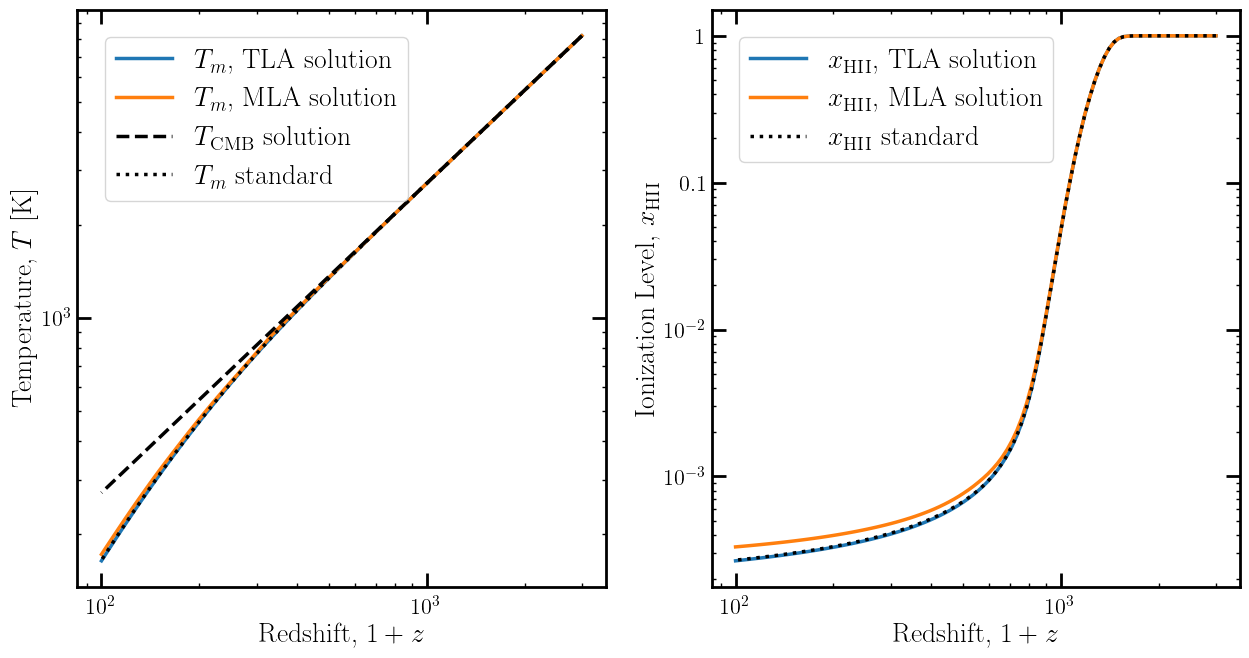

In [140]:
fig, axarr = plt.subplots(1, 2, figsize=(2*7.5, 7.5))


#----- Fig 1 ----#
axarr[0].loglog()
axarr[0].plot(rs_list, soln_TLA[:,0]/phys.kB, label=r'$T_m$, TLA solution')
axarr[0].plot(rs_list, soln_MLA[:,0]/phys.kB, label=r'$T_m$, MLA solution')

axarr[0].plot(rs_list, phys.TCMB(rs_list)/phys.kB, 
              color='k', linestyle='--', label=r'$T_{\mathrm{CMB}}$ solution')
axarr[0].plot(rs_list, phys.Tm_std(rs_list)/phys.kB, 
              color='k', linestyle=':', label=r'$T_m$ standard')
axarr[0].set_xlabel(r'Redshift, $1+z$', fontsize=20)
axarr[0].set_ylabel(r'Temperature, $T$ [K]', fontsize=20)
axarr[0].legend(fontsize=20)
#----------------#
#----------------#



#----- Fig 2 ----#
axarr[1].loglog()
axarr[1].plot(rs_list, soln_TLA[:,1], label=r'$x_{\mathrm{HII}}$, TLA solution')
axarr[1].plot(rs_list, soln_MLA[:,1], label=r'$x_{\mathrm{HII}}$, MLA solution')

axarr[1].plot(rs_list, phys.xHII_std(rs_list), 
              color='k', linestyle=':', label=r'$x_{\mathrm{HII}}$ standard')
axarr[1].set_xlabel(r'Redshift, $1+z$', fontsize=20)
axarr[1].set_ylabel(r'Ionization Level, $x_{\mathrm{HII}}$', fontsize=20)
axarr[1].legend(fontsize=20)

# axarr[1].axvline(rs_div, color='k', linestyle=':')
#----------------#
#----------------#

In [141]:
ind1=5

start_rs = rs_vec[-ind1]
data=np.zeros((length-(ind1-1),2))
data[-1] = np.array([
    np.log(phys.Tm_std(start_rs)), 
    np.arctanh(2*(phys.xHII_std(start_rs) - 0.5))
])

lim = 5
for k in np.arange(lim):
    x2 = x2_vec[-ind1-k]
    Tr = Tr_vec[-ind1-k]
    Tm = Tm_vec[-ind1-k]
    
    beta_tmp  = phys.beta_ion(Tr,'HI') * x2
    alpha_tmp = phys.alpha_recomb(Tm, 'HI')/1.125
    
    rs_diff = rs_vec[-ind1-k:-ind1-(k+2):-1]
    
    soln = tmp_tla(rs_diff, data[-1-k], alpha_tmp, beta_tmp)
    
    data[-2-k] = soln[-1]
    
data[:,0] = np.exp(data[:,0])/phys.kB
data[:,1] = 0.5 + 0.5*np.tanh(data[:,1])

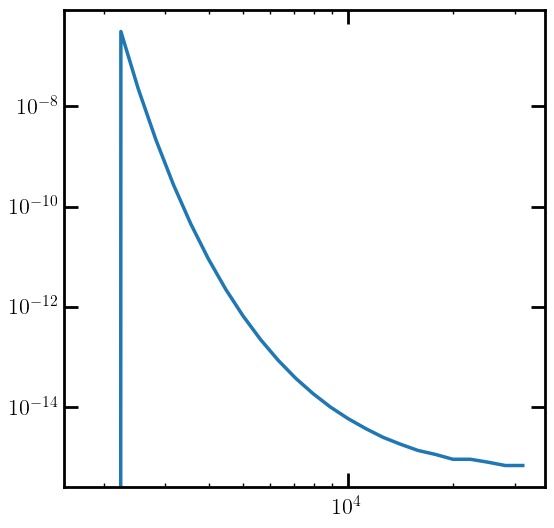

In [127]:
plt.figure()
plt.loglog()
plt.plot(rs_vec[-1-lim:], 1-data[-1-lim:,1])


# Distortion

In [949]:
%autoreload
mDM = 3e10
# sigmav = xsec_bound_elec_CMB(mDM,'swave')
tau=1e25
species = 'elec'
DM_process = 'decay'
string = str(int(np.floor(np.log10(mDM))))
test_main = main.evolve(
    DM_process=DM_process, mDM=mDM,
    lifetime=tau,
    primary=species+'_delta',
    start_rs = 3e3,
    coarsen_factor=12, backreaction=False, distort=False,
#     struct_boost=struct_boost,
    end_rs=2.5e3
)

In [950]:
spec10  = test_main['highengphot'][-1]
spec10.redshift(1)

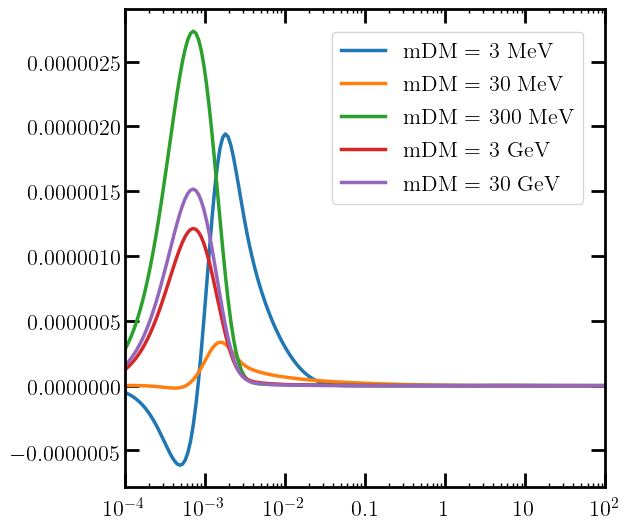

In [951]:
plt.figure()
plt.xscale('log')
plt.xlim([1e-4,100])
plt.plot(spec6.eng, spec6.eng*spec6.dNdE, label='mDM = 3 MeV')
plt.plot(spec.eng, spec.eng*spec.dNdE, label='mDM = 30 MeV')
plt.plot(spec8.eng, spec8.eng*spec8.dNdE, label='mDM = 300 MeV')
plt.plot(spec9.eng, spec9.eng*spec9.dNdE, label='mDM = 3 GeV')
plt.plot(spec10.eng, spec10.eng*spec10.dNdE, label='mDM = 30 GeV')
plt.legend()

$$
I =  \frac{h c E}{4 \pi} \frac{dn}{dE}
$$

In [307]:
hplanck = phys.hbar * 2 * np.pi

nu_range = np.logspace(-1,np.log10(1.75e12), 100)
eng_range = hplanck * nu_range

(10000000.0, 10000000000000.0, 1e-24, 1e-17)

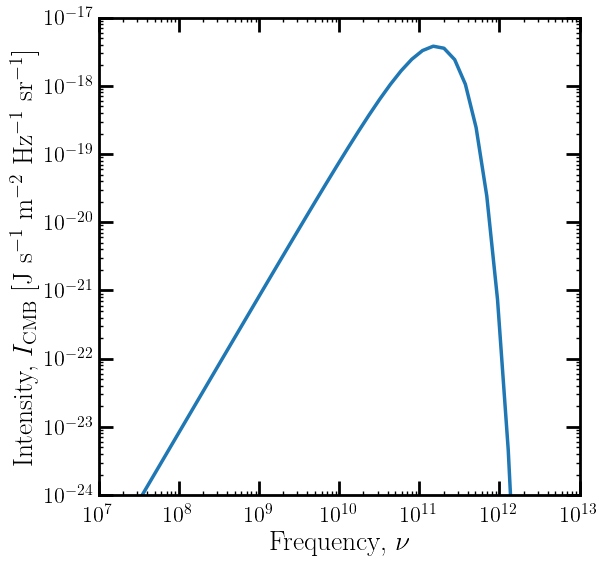

In [320]:
hplanck = phys.hbar * 2 * np.pi

nu_range = np.logspace(-1,np.log10(1.75e12), 100)
eng_range = hplanck * nu_range

dNdE = phys.CMB_spec(eng_range, phys.TCMB(1))
convert = eng_range * hplanck * phys.c /(4*np.pi) * phys.ele * 1e4


plt.figure()
plt.loglog()

plt.plot(nu_range, convert * dNdE)
plt.xlabel(r'Frequency, $\nu$', fontsize=20)
plt.ylabel(r'Intensity, $I_{\mathrm{CMB}}$ [J s$^{-1}$ m$^{-2}$ Hz$^{-1}$ sr$^{-1}$]', fontsize=20)
plt.axis([1e7, 1e13, 1e-24, 1e-17])